# Installation

Python version: python3.8 -q

In [ ]:
feature_cols = [
    'Volume', 'ROC_Volume',
    'EMROC_Volume', 'ATR_10',
    'RSI', 'DistanceToMM20', 'DistanceToMM60', 'DistanceToEMM20',
    'DistanceToEMM60'
]

# The Data

When fetching the ticker ES=F from Yahoo Finance, we obtain these columns:

Price	       Datetime	             Close	 High	  Low	 Open	Volume
0	    2024-02-22 17:00:00-06:00	5099.00	5100.50	5094.00	5094.25	0
1	    2024-02-22 18:00:00-06:00	5095.75	5099.25	5092.25	5098.75	9420
2	    2024-02-22 19:00:00-06:00	5099.50	5101.75	5095.00	5095.75	7390
3	    2024-02-22 20:00:00-06:00	5100.25	5102.50	5099.50	5099.75	4922
4	    2024-02-22 21:00:00-06:00	5101.25	5102.00	5099.75	5100.50	4426

The date time format corresponds to:

- YYYY-MM-DD → The date (Year-Month-Day)
- HH:MM:SS → The time in 24-hour format (Hour:Minute:Second)
- 06:00 → The timezone offset from UTC, which in this case is UTC-6 (Central Time, since you set tz="America/Chicago")



# Checkpoint

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler

def preprocess_features(df, feature_cols):
    """
    Preprocess features with robust handling of outliers and infinite values
    """
    features = df[feature_cols].select_dtypes(include=[np.number]).copy()

    # Replace infinite values with NaN
    features = features.replace([np.inf, -np.inf], np.nan)

    # Calculate robust statistics for each column
    medians = features.median()
    q1 = features.quantile(0.25)
    q3 = features.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace outliers and NaN values with median
    for col in features.columns:
        mask = (features[col] < lower_bound[col]) | (features[col] > upper_bound[col]) | features[col].isna()
        features.loc[mask, col] = medians[col]

    return features

def analyze_shap_values_with_beeswarm(df, feature_cols, target_cols):
    """
    Analyze SHAP values and create beeswarm plots for multiple targets using DeepSHAP
    With robust preprocessing and outlier handling
    """
    print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))

    # Robust preprocessing
    print("Preprocessing features...")
    features = preprocess_features(df, feature_cols)

    # Standardize features
    scaler = StandardScaler()
    features_scaled = pd.DataFrame(
        scaler.fit_transform(features),
        columns=features.columns,
        index=features.index
    )

    results = {}
    shap_values_dict = {}

    for target in target_cols:
        print(f"\nTraining model for target: {target}")

        # Prepare target variable with robust preprocessing
        y = df[target].copy()
        y = y.replace([np.inf, -np.inf], np.nan)
        y_median = y.median()
        y_q1 = y.quantile(0.25)
        y_q3 = y.quantile(0.75)
        y_iqr = y_q3 - y_q1
        y_lower = y_q1 - 1.5 * y_iqr
        y_upper = y_q3 + 1.5 * y_iqr
        mask = (y < y_lower) | (y > y_upper) | y.isna()
        y[mask] = y_median

        # Standardize target
        y_scaled = (y - y.mean()) / y.std()

        # Build model
        model = Sequential([
            Dense(128, input_shape=(features.shape[1],)),
            BatchNormalization(),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1, activation='linear')
        ])

        # Compile with smaller learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        # Train with early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=3,
            restore_best_weights=True
        )

        # Verify data is finite
        assert np.all(np.isfinite(features_scaled)), "Features contain non-finite values"
        assert np.all(np.isfinite(y_scaled)), "Target contains non-finite values"

        print(f"Feature stats - min: {features_scaled.min().min():.2f}, max: {features_scaled.max().max():.2f}")
        print(f"Target stats - min: {y_scaled.min():.2f}, max: {y_scaled.max():.2f}")

        # Train the model
        history = model.fit(
            features_scaled,
            y_scaled,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        print(f"Final training loss: {history.history['loss'][-1]:.4f}")

        try:
            print("Calculating SHAP values...")
            # Use first 100 samples as background
            background = features_scaled.iloc[:100]
            explainer = shap.DeepExplainer(model, background)

            # Calculate SHAP values in smaller batches
            batch_size = 500
            all_shap_values = []

            for i in range(0, len(features_scaled), batch_size):
                batch = features_scaled.iloc[i:i+batch_size]
                batch_values = explainer.shap_values(batch)

                if isinstance(batch_values, list):
                    batch_values = batch_values[0]

                all_shap_values.append(batch_values)

            shap_values = np.vstack(all_shap_values)

            # Store results
            results[target] = pd.DataFrame({
                'feature': feature_cols,
                'importance': np.abs(shap_values).mean(axis=0)
            }).sort_values('importance', ascending=False)

            shap_values_dict[target] = {
                'values': shap_values,
                'features': features_scaled
            }

            # Create and save plot
            plt.figure(figsize=(12, 8))
            shap.plots.beeswarm(
                shap.Explanation(
                    values=shap_values,
                    data=features_scaled,
                    feature_names=features_scaled.columns
                ),
                max_display=20
            )
            plt.title(f'SHAP Values Beeswarm Plot for {target}')
            plt.tight_layout()

            plot_filename = f"SHAP/{target}_SHAP_beeswarm_plot.png"
            plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
            #plt.close()

        except Exception as e:
            print(f"Error processing {target}: {str(e)}")
            continue

    return results, shap_values_dict

# Example usage:
# score_results, score_shap_values = analyze_shap_values_with_beeswarm(
#     df,
#     feature_cols=feature_cols,
#     target_cols=['SIGN_1']
# )

In [ ]:
%pip install tensorflow==2.3.0

In [ ]:
import tensorflow as tf
import pip

pip.main(['install', 'tensorflow==2.3.0'])

In [ ]:
df = data.copy()
for i in range(1, 2):
  score_results, score_shap_values = analyze_shap_values_with_beeswarm(
      df,
      feature_cols=feature_cols,
      target_cols=[f'SIGN_{i}']  # Using fewer targets for clarity
  )

"""
# Similarly for SIGN and APE:
sign_results = analyze_shap_values(df, feature_cols, [f'SIGN_{i}' for i in range(1, 13)])
ape_results = analyze_shap_values(df, feature_cols, [f'APE_{i}' for i in range(1, 13)])

plot_feature_importance(sign_results, 'SIGN')
plt.show()
plot_feature_importance(ape_results, 'APE')
plt.show()
"""

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure the output directory exists
os.makedirs("plots", exist_ok=True)

"""
max_sign_value = -float("inf")
min_sign_value = float("inf")

max_ape_value = -float("inf")
min_ape_value = float("inf")

max_score_value = -float("inf")
min_score_value = float("inf")
"""

for target in targets:
    plt.figure(figsize=(14, 8))

    """
    max_value = -float("inf")
    min_value = float("inf")
    """

    if "SIGN" in target:
        max_value = max_sign_value
        min_value = min_sign_value

    elif "APE" in target:
        max_value = max_ape_value
        min_value = min_ape_value

    elif "SCORE" in target:
        max_value = max_score_value
        min_value = min_score_value


    for variable in variables:
        df = data.copy()
        df[f"{variable}_bucket"] = pd.qcut(df[variable], 10, labels=False)

        # Calculate bucket means
        bucket_means = df.groupby(f"{variable}_bucket")[target].mean().reset_index()

        # Find the maximum and minimum values
        """
        max_value = max(max_value, bucket_means[target].max())
        min_value = min(min_value, bucket_means[target].min())
        """

        # Plot each variable on the same plot
        plt.plot(bucket_means[f"{variable}_bucket"],
                 bucket_means[target],
                 marker='o',
                 label=variable)
    """
    if target[-2:] != "_1":
        if "SIGN" in target:
            max_sign_value = max(max_sign_value, max_value)
            min_sign_value = min(min_sign_value, min_value)

        elif "APE" in target:
            max_ape_value = max(max_ape_value, max_value)
            min_ape_value = min(min_ape_value, min_value)

        elif "SCORE" in target:
            max_score_value = max(max_score_value, max_value)
            min_score_value = min(min_score_value, min_value)
    """
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)


    if target[-2:] != "_1":
        plt.ylim(min_value, max_value)


    # Add plot details
    plt.xlabel('Percentile Bucket')
    plt.ylabel(f'Mean {target}')
    plt.title(f'Mean {target} Across Different Variables per Percentile Bucket')
    plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save plot
    plot_filename = f"plots/{target}_grouped_percentile_plot.png"
    plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Grouped plot saved as {plot_filename}")


In [ ]:
sign_lim = (min_sign_value, max_sign_value)
ape_lim = (min_ape_value, max_ape_value)
score_lim = (min_score_value, max_score_value)

In [ ]:
sign_lim

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Assuming 'data' is already defined with your features and target

classifiers = dict()
index = 1

# Loop through all columns with 'SIGN_' to train models
for col in data.columns:
    if "SIGN_" in col:
        X = data[['Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos',
                  "EMROC_Close", "EMROC_Volume", "ATR_10", "RSI", 'DistanceToMM20',
                  'DistanceToMM60', 'DistanceToEMM20', 'DistanceToEMM60']]
        y = data[col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize the RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        classifiers[index] = {
            "model": rf,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        }

        index += 1

# You can also check for other time-related correlations, such as Day or Week

In [ ]:
! zip -r plots.zip plots

In [ ]:
predictions_dfs = dict()

for key, values in classifiers.items():
    value = list(values.values())
    predictions = value[0].predict(value[2])
    predictions_df = data[['Hour', 'Day', 'Week', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos',
                  "EMROC_Close", "EMROC_Volume", "ATR_10", "RSI", 'DistanceToMM20',
                  'DistanceToMM60', 'DistanceToEMM20', 'DistanceToEMM60']].copy()

    predictions_df = pd.concat([predictions_df, value[4]], axis=1)
    predictions_df.dropna(inplace=True)
    predictions_df[f"SIGN_{key}_Prediction"] = predictions
    predictions_df["Result"] = predictions_df[f"SIGN_{key}_Prediction"] == predictions_df[f"SIGN_{key}"]
    predictions_dfs[key] = predictions_df
    print(classification_report(value[4], value[0].predict(value[2])))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: assuming Hour is [0..23], Day is [0..6], Week is a numeric week index.
# If these are not the correct ranges or formats, adjust accordingly.

for i, df in enumerate(predictions_dfs.values(), 1):
    # Group and compute mean performance
    hour_performance = df.groupby('Hour')['Result'].mean()  # Keep natural hourly order
    day_performance = df.groupby('Day')['Result'].mean()    # Keep natural daily order
    week_performance = df.groupby('Week')['Result'].mean()  # Keep natural weekly order

    # Create a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle(f'Model Performance Patterns (DataFrame #{i})', fontsize=16, y=0.95)

    # Hourly performance plot
    sns.barplot(x=hour_performance.index, y=hour_performance.values, ax=axs[0], color="skyblue")
    axs[0].set_title('Mean Performance by Hour', fontsize=14)
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Mean Result')

    # Daily performance plot
    sns.barplot(x=day_performance.index, y=day_performance.values, ax=axs[1], color="lightgreen")
    axs[1].set_title('Mean Performance by Day', fontsize=14)
    axs[1].set_xlabel('Day of the Week')
    axs[1].set_ylabel('Mean Result')
    # If day coding is known (e.g., 0=Monday), add custom labels:
    axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Weekly performance plot
    sns.barplot(x=week_performance.index, y=week_performance.values, ax=axs[2], color="salmon")
    axs[2].set_title('Mean Performance by Week', fontsize=14)
    axs[2].set_xlabel('Week')
    axs[2].set_ylabel('Mean Result')

    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example DataFrame (replace with your data)
df = pd.read_csv('results_BTC=F_384.csv')

# Select the variable to segment by (e.g., 'ATR_10')
variable = 'ATR_10'
targets = ['score', 'APE', 'SIGN']

# Step 1: Find dynamic thresholds using KMeans
def get_thresholds(data, n_clusters=3):
    valid_data = data.dropna().values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(valid_data)
    thresholds = sorted(kmeans.cluster_centers_.flatten())
    return thresholds

# Step 2: Create segments
def segment_data(df, variable, thresholds):
    df['segment'] = pd.cut(df[variable], bins=[-np.inf] + thresholds + [np.inf], labels=False)
    return df

# Step 3: Plot histograms for targets across segments
def plot_histograms(df, targets):
    for target in targets:
        plt.figure(figsize=(10, 6))
        for segment in sorted(df['segment'].unique()):
            subset = df[df['segment'] == segment]
            plt.hist(subset[target].dropna(), alpha=0.5, label=f'Segment {segment}', bins=30)
        plt.title(f'{target} Distribution Across {variable} Segments')
        plt.xlabel(target)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# Main execution
if variable in df.columns:
    thresholds = get_thresholds(df[variable])
    df = segment_data(df, variable, thresholds)
    plot_histograms(df, targets)
else:
    print(f"Variable {variable} not found in DataFrame columns.")


In [ ]:
str(df.describe())

In [ ]:
df.describe()

# Precision Comparison

### Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

### Precision function

In [ ]:
def precision(file_path, 
              data=None, 
              rf=False, 
              target="Close_denoised_standardized",
              horizon=3, 
              threshold_column=None, 
              quantile=0, 
              day=None, 
              hour=None,
              months=None,
              years=None):
        
    if data is None:
        # Ensure pandas reads the index as datetime and preserves timezone
        df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    else:
        df = data.copy()

    df.dropna(inplace=True)  # remove NaN values
    # Force index to be in datetime format
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True)  # Convert to datetime, force UTC

    # Convert from UTC to local time (assuming original data is in GMT-6)
    df.index = df.index.tz_convert("America/Chicago")  # Convert to Central Time

    # Remove timezone information, keeping the displayed local time
    df.index = df.index.tz_localize(None)

    df['Month'] = df.index.month
    df["Year"] = df.index.year
    df["Month"] = df.index.month
    
            
    def atr(target, horizon=3, threshold_column=None, q=0):
        i = 0
        TP = [0 for _ in range(horizon)]
        TN = [0 for _ in range(horizon)]
        FP = [0 for _ in range(horizon)]
        FN = [0 for _ in range(horizon)]
        
        if threshold_column is not None:
            threshold = df[threshold_column].quantile(q)

        if rf:
            for i in range(len(df)):
                if threshold_column is not None and df[threshold_column].iloc[i] <= threshold:
                    continue

                # the computation just below is false. See the one without RF
                for j in range(horizon):
                    if df[f"Pred Evolution {j+1}"].iloc[i] == 1 and df[f"Evolution {j+1}"].iloc[i] == 1:
                        TP[j] += 1
                    elif df[f"Pred Evolution {j+1}"].iloc[i] == 1:
                        FP[j] += 1
                    elif df[f"Pred Evolution {j+1}"].iloc[i] == -1 and df[f"Evolution {j+1}"].iloc[i] == -1:
                        TN[j] += 1
                    elif df[f"Pred Evolution {j+1}"].iloc[i] == -1:
                        FN[j] += 1
            # Return precision for each horizon step
            return [tp / (tp + fp) if (tp + fp) != 0 else 0 for tp, fp in zip(TP, FP)]
        
 
        while i < len(df) - 13:  # - 13 to avoid index out of range (predict next 12 hours). What are the last 13 values?
            try:

                # day/hour filtering (original code)
                if day is not None and df["Day"].iloc[i] != day:
                    i += 1
                    continue
                if hour is not None and df["Hour"].iloc[i] != hour:
                    i += 1
                    continue

                # Filter by months if provided
                if years is not None and df["Year"].iloc[i] not in years:
                    i += 1
                    continue
                if months is not None and df["Month"].iloc[i] not in months:
                    i += 1
                    continue

                # threshold filter (original code)
                if threshold_column is not None and df[threshold_column].iloc[i] <= threshold:
                    i += 1
                    continue

                # actual signs calculation (original code)
                base = df[target].iloc[i]
                signs = []
                for j in range(1, horizon + 1):
                    y = df[target].iloc[i + j]
                    signs.append(int(np.sign(y - base)))

                    # y - base > 0 => y > base => up => + 1
                    # y - base < 0 => y < base => down => - 1

                pred_signs = ast.literal_eval(df["SIGN"].iloc[i+1])

                # confusion matrix updates (original code)
                for j in range(horizon):
                    if pred_signs[j] == 1 and signs[j] == 1:
                        TP[j] += 1
                    elif pred_signs[j] == 1 and signs[j] == -1:
                        TN[j] += 1
                    elif pred_signs[j] == -1 and signs[j] == 1: # pred => down actual => up
                        FN[j] += 1
                    elif pred_signs[j] == -1 and signs[j] == -1: # pred => up actual => down
                        FP[j] += 1
            except Exception as e:
                print(i, e)
                break


        print(f"True Positive (TP): {TP}, True Negative (TN): {TN}, "
              f"False Positive (FP): {FP}, False Negative (FN): {FN}")
        
        return list(map(lambda x: x[0]/(x[0]+x[1]), zip(TP, FP)))

    # Return the final list of precision values for each horizon
    return atr(target, horizon, threshold_column, quantile)

### Constants

This section stores constants for all sections that generate heatmap.
There are values and labels for year, quarter, month, day, hour (+ day and night), horizon and models

In [1]:
###############################################
# Constants
###############################################

years = [2023, 2024]

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
}
day_labels = [v for k,v in days.items()]

hours = {
    0: "12AM",  1: "1AM",  2: "2AM",  3: "3AM",  4: "4AM",  5: "5AM",
    6: "6AM",  7: "7AM",  8: "8AM",  9: "9AM",  10: "10AM", 11: "11AM",
    12: "12PM", 13: "1PM", 14: "2PM", 15: "3PM", 16: "4PM", 17: "5PM",
    18: "6PM", 19: "7PM", 20: "8PM", 21: "9PM", 22: "10PM", 23: "11PM"
}

hour_labels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v']

day_hours = {0: "8AM",  1: "9AM",  2: "10AM", 3: "11AM", 4: "12PM", 5: "1PM", 6: "2PM", 7: "3PM", 8: "4PM"}
day_hours_labels = ['8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']

night_hours = {0: "5PM", 1: "6PM", 2: "7PM", 3: "8PM", 4: "9PM", 5: "10PM", 6: "11PM", 7: "12AM", 8: "1AM",  9: "2AM",  10: "3AM",  11: "4AM",  12: "5AM", 13: "6AM",  14: "7AM"}
night_hours_labels = ['5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM']

months = {i: i+1 for i in range(12)}
months_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

quarters = [1, 2, 3, 4]
quarters_label = ['Q1', 'Q2', 'Q3', 'Q4']

horizons = [0, 1, 2]
horizons_label = [1, 2, 3]

future = "es"
models = {0: "moirai", 1: "chronos", 2: "time_moe"}

### Helper functions to plot heatmaps

This helper function creates an extended heatmap with averages for rows and columns.

In [3]:
def create_extended_heatmap_data(base_data, tp_data, fp_data):
    """
    Return an extended array that appends:
      - A new last column with each row's ratio-of-sums
      - A new last row with each column's ratio-of-sums
      - The bottom-right cell with the ratio-of-total-sums
    base_data: the cell-level precision
    tp_data, fp_data: the sums of TPs and FPs for each cell
    """
    n_rows, n_cols = base_data.shape

    # Prepare the extended array
    extended = np.zeros((n_rows + 1, n_cols + 1), dtype=float)

    # Fill in the main area
    extended[:n_rows, :n_cols] = base_data

    # Compute row-average via ratio of sums
    for r in range(n_rows):
        row_tp = np.sum(tp_data[r, :])
        row_fp = np.sum(fp_data[r, :])
        if row_tp + row_fp > 0:
            extended[r, -1] = row_tp / (row_tp + row_fp)
        else:
            extended[r, -1] = 0.0

    # Compute column-average via ratio of sums
    for c in range(n_cols):
        col_tp = np.sum(tp_data[:, c])
        col_fp = np.sum(fp_data[:, c])
        if col_tp + col_fp > 0:
            extended[-1, c] = col_tp / (col_tp + col_fp)
        else:
            extended[-1, c] = 0.0

    # Bottom-right cell: ratio of total TPs / total (TPs+FPs)
    total_tp = np.sum(tp_data)
    total_fp = np.sum(fp_data)
    if total_tp + total_fp > 0:
        extended[-1, -1] = total_tp / (total_tp + total_fp)
    else:
        extended[-1, -1] = 0.0

    return extended

In [4]:
def plot_extended_heatmap(extended_data, x_labels, y_labels, xlabel, ylabel, title,
                          cmap=plt.cm.RdYlGn, norm_range=(0.45, 0.75), figsize=(10, 8)):
    """
    Plot the heatmap given the extended data and labels.
    The x_labels and y_labels should include the label for the extra (average) column/row.
    """

    # Create an extra column and row for the averages
    x_labels = x_labels + ['Avg']
    y_labels = y_labels + ['Avg']

    plt.figure(figsize=figsize)
    norm = plt.Normalize(*norm_range)
    plt.imshow(extended_data, cmap=cmap, norm=norm, aspect='auto')
    plt.colorbar(label='Mean Precision')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Annotate each cell with its numeric value
    for i in range(extended_data.shape[0]):
        for j in range(extended_data.shape[1]):
            plt.text(j, i, f"{extended_data[i, j]:.2f}", ha='center', va='center', color='black')
    plt.tight_layout()
    plt.savefig(f"../temporary_heatmaps/{title}.png", dpi=300, bbox_inches='tight')
    plt.show()

### Testing purpose

Do not pay attention to this section

In [ ]:
# # Compute the precison for every model, day, hour and horizon
# heatmaps = dict() # this dict will store all values and will be organized using keys like "model_day_hour_horizon"
# for model_label in models:
#     for day_index, _ in days.items():
#         for hour_index, _ in hours.items():
#             precisions = precision(file_path=f"../future_data/{future}_future_final_{model_label}.csv", day = day_index, hour = hour_index, horizon=len(horizons), target="Close") # store all the precisions for each horizon
#             for horizon_index in horizons:
#                 heatmaps[f"{model_label}_{day_index}_{hour_index}_{horizon_index}"] = precisions[horizon_index]


# ###############################################
# # Heatmap (days x hours)
# ###############################################

# base_data = np.zeros((len(hours), len(days))) # Create the base 2D array (Days x Hours)
# for hour_index, _ in hours.items():
#     for day_index, _ in days.items():
#         # Calculate mean precision over all models and horizons for a given hour and day
#         precisions = [
#             heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
#             for model in models
#             for horizon in horizons
#         ]
#         base_data[hour_index, day_index] = np.mean(precisions)

# # Compute extended data and prepare labels
# extended_data = create_extended_heatmap_data(base_data)

# plot_extended_heatmap(extended_data, 
#                       x_labels=day_labels,
#                       y_labels=hour_labels,
#                       xlabel="Day of the Week",
#                       ylabel="Entry Hour",
#                       title="Mean Precision Heatmap (Days x Hours)")


# ###############################################
# # Heatmap (Days x Hours) - Only day hours (8AM - 4PM)
# ###############################################

# base_data = np.zeros((len(day_hours), len(days)))

# for i, (hour_index, _) in enumerate(day_hours.items()):
#     for j, (day_index, _) in enumerate(days.items()):
#         precisions = [
#             heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
#             for model in models
#             for horizon in horizons
#         ]
#         base_data[i, j] = np.mean(precisions)

# extended_data = create_extended_heatmap_data(base_data)

# plot_extended_heatmap(extended_data,
#                       x_labels=day_labels,
#                       y_labels=day_hours_labels,
#                       xlabel="Day of the Week",
#                       ylabel="Entry Hour (day hours)",
#                       title="Mean Precision Heatmap (Days x Hours) - day hours")

# ###############################################
# # Heatmap (Days x Hours) - Only night hours (5PM - 7AM)
# ###############################################

# base_data = np.zeros((len(night_hours), len(days)))

# for i, (hour_index, _) in enumerate(night_hours.items()):
#     for j, (day_index, _) in enumerate(days.items()):
#         precisions = [
#             heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
#             for model in models
#             for horizon in horizons
#         ]
#         base_data[i, j] = np.mean(precisions)

# extended_data = create_extended_heatmap_data(base_data)

# plot_extended_heatmap(extended_data,
#                       x_labels=day_labels,
#                       y_labels=night_hours_labels,
#                       xlabel="Day of the Week",
#                       ylabel="Entry Hour (night hours)",
#                       title="Mean Precision Heatmap (Days x Hours) - night hours")

### New precision function

This code is used to explain how do we compute the signs and the predictions. It is not used in practice, it is for demonstration only.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

def precision_per_day(file_path, 
              target="Close",
              horizon=3, 
              date=None):

    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    df.dropna(inplace=True)  # remove NaN values
    # Force index to be in datetime format
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True)  # Convert to datetime, force UTC
    # Convert from UTC to local time (assuming original data is in GMT-6)
    df.index = df.index.tz_convert("America/Chicago")  # Convert to Central Time
            
    df['Row_Position'] = range(len(df))  # Add original row position column

    df_date = df.loc[date]  # Filter rows by date
    
    df_date_index_start = df_date.iloc[0]["Row_Position"]
    df_date_index_end = df_date.iloc[-1]["Row_Position"]

    # We take extra values (as many as there are horizons) to be able to predict the sign
    # Correctly extract future timestamps from df.index
    df_ground_truth_start_time = df.index[df_date_index_start + 1]
    df_ground_truth_end_time = df.index[df_date_index_end + horizon]  # Prevent out-of-bounds

    df_ground_truth = df.loc[df_ground_truth_start_time : df_ground_truth_end_time]

    TP = [0 for _ in range(horizon)]
    TN = [0 for _ in range(horizon)]
    FP = [0 for _ in range(horizon)]
    FN = [0 for _ in range(horizon)]


    #print("\n ---------- \nDate: ", date)
    #print("Ground truth start time: ", df_ground_truth_start_time)
    #print("Ground truth end time: ", df_ground_truth_end_time)

    # for each day
    for index, row in df_date.iterrows():
        #print("\n")
        #print("Hour: ", index)
        row_index = row["Row_Position"]
        base = row[target]
        results_list = ast.literal_eval(row["Result"])
        
        for horizon_index in range(1, horizon+1):
            #print("Horizon n°", horizon_index)
            # locate the row + horizon_index 
            future_time = df.index[row_index + horizon_index]
            y = df_ground_truth.loc[future_time, target]
            prediction_result = results_list[horizon_index-1]
            #print("Base: ", base, "Real: ", y, "Prediction: ", prediction_result)
            sign_real_difference = np.sign(y - base)
            sign_prediction_difference = np.sign(prediction_result - base)
            #print("Real sign difference: ", sign_real_difference)
            #print("Prediction sign difference: ", sign_prediction_difference)
            
            if sign_prediction_difference == 1 and sign_real_difference == 1:
                TP[horizon_index-1] += 1
            elif sign_prediction_difference == -1 and sign_real_difference == -1:
                TN[horizon_index-1] += 1
            elif sign_prediction_difference == 1 and sign_real_difference == -1:
                FP[horizon_index-1] += 1
            elif sign_prediction_difference == -1 and sign_real_difference == 1:
                FN[horizon_index-1] += 1
            else:
                print("Error with signs. See the following values:")
                print(f"Real: {sign_real_difference}, Prediction: {sign_prediction_difference}")
                print(f"Real: {y}, Prediction: {prediction_result}")
    return TP, TN, FN, FP

### Helper function to compute the TP, FP, TN, FN for every row of the dataframe - Use only once

In [ ]:
def helper_metric(filepath: str):

    df = pd.read_csv(f"{filepath}.csv", parse_dates=True, index_col=0)

    # Add 4 columns named "TP", "TN", "FP", "FN" to the dataframe
    df["TP"] = 0
    df["TN"] = 0
    df["FP"] = 0
    df["FN"] = 0

    first_predicted_row = 383
    last_predicted_row = len(df) - 12
    
    for index, row in df[first_predicted_row:last_predicted_row].iterrows():
        base_price = row['Close']
        future_predictions = ast.literal_eval(row["Result"])
        future_prices = df.loc[index:].iloc[1:13]["Close"].tolist() # get the next 12 values corresponding to the next 12 horizons
        real_difference_signs = [np.sign(price - base_price) for price in future_prices]
        predicted_difference_signs = [np.sign(prediction - base_price) for prediction in future_predictions]

        TP = [0 for _ in range(12)]
        TN = [0 for _ in range(12)]
        FP = [0 for _ in range(12)]
        FN = [0 for _ in range(12)]

        for horizon_index, (real_difference_sign, predicted_difference_sign) in enumerate(zip(real_difference_signs, predicted_difference_signs)):
            if real_difference_sign == predicted_difference_sign and real_difference_sign == 1:
                TP[horizon_index-1] += 1
            elif real_difference_sign == predicted_difference_sign and real_difference_sign == -1:
                TN[horizon_index-1] += 1
            elif real_difference_sign != predicted_difference_sign and real_difference_sign == 1:
                FN[horizon_index-1] += 1
            elif real_difference_sign != predicted_difference_sign and real_difference_sign == -1:
                FP[horizon_index-1] += 1

        # fill the column for TP, TN, FP, FN for the current row
        df.at[index, "TP"] = str(TP)
        df.at[index, "TN"] = str(TN)
        df.at[index, "FP"] = str(FP)
        df.at[index, "FN"] = str(FN)
        
    df.to_csv(f"{filepath}_updated.csv", index=True)

for model in models:
    helper_metric(filepath=f"../future_data/es_future_final_{model}")

### Final code to compute precision for all heatmaps

In [18]:
import numpy as np
import pandas as pd
import ast
from typing import List, Dict
from datetime import datetime


def initialize_heatmaps(x_values: Dict[int, str], y_values: Dict[int, str], horizons: List[int]) -> Dict[str, Dict[str, List[int]]]:

    """Initialize heatmaps dictionary to store TP and FP values."""
    return {
        f"{x_index}_{y_index}": {"TP": [0] * len(horizons), "FP": [0] * len(horizons)}
        for x_index, _ in enumerate(x_values) for y_index, _ in enumerate(y_values)
    }

def initialize_data_matrices(len_x_values: int, len_y_values: int):
    """Initialize matrices to store TP, FP, and precision values."""
    return (
        np.zeros((len_y_values, len_x_values), dtype=float),  # tp_data
        np.zeros((len_y_values, len_x_values), dtype=float),  # fp_data
        np.zeros((len_y_values, len_x_values), dtype=float)   # precisions
    )

def load_model_data(model: str) -> pd.DataFrame:
    """Load CSV file for a given model."""
    return pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)


def update_matrices(heatmaps, tp_data, fp_data, x_values, y_values):
    """Update TP and FP matrices based on heatmaps data."""
    for x_index, _ in enumerate(x_values):
        for y_index, _ in enumerate(y_values):
            key = f"{x_index}_{y_index}"
            tp_data[y_index, x_index] = sum(heatmaps[key]["TP"])
            fp_data[y_index, x_index] = sum(heatmaps[key]["FP"])

def fill_precisions(precisions, tp_data, fp_data):
    """
    Fill precisions with precision = TP / (TP + FP).
    This is a helper function to encapsulate the logic of computing precisions.
    """
    len_x_values, len_y_values = precisions.shape
    for x in range(len_x_values):
        for y in range(len_y_values):
            total = tp_data[x, y] + fp_data[x, y]
            if total > 0:
                precisions[x, y] = tp_data[x, y] / total
            else:
                precisions[x, y] = 0.0


def precision(models: List[str], x_values, y_values, x_labels, y_labels, xlabel, ylabel, title, day_hours_bool: bool, night_hours_bool: bool, all_hours_bool: bool, process_row, **kwargs):
    """Compute precision matrices for each model, fill precisions, and plot extended heatmap."""

    len_x_values = len(x_values)
    len_y_values = len(y_values)

    # 1. Initialize data structures
    heatmaps = initialize_heatmaps(x_values, y_values, horizons)
    tp_data, fp_data, precisions = initialize_data_matrices(len_x_values, len_y_values)

    # 2. Collect TP and FP values from each model
    for model_index, model in models.items():
        df = load_model_data(model)
        first_predicted_row, last_predicted_row = 383, len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            kwargs["index"], kwargs["model_index"], kwargs["row"], kwargs["heatmaps"], kwargs["horizons"],kwargs["day_hours_bool"], kwargs["night_hours_bool"], kwargs["all_hours_bool"] = index, model_index, row, heatmaps, horizons, day_hours_bool, night_hours_bool, all_hours_bool
            process_row(**kwargs)

    # 3. Aggregate results into tp_data and fp_data
    update_matrices(heatmaps, tp_data, fp_data, x_values, y_values)

    # 4. Fill precisions with the ratio = TP / (TP + FP)
    fill_precisions(precisions, tp_data, fp_data)

    # 5. Build extended heatmap data & plot
    extended_data = create_extended_heatmap_data(precisions, tp_data, fp_data)
    plot_extended_heatmap(
        extended_data, 
        x_labels=x_labels,
        y_labels=y_labels,
        xlabel=xlabel,
        ylabel=ylabel,
        title=title
    )

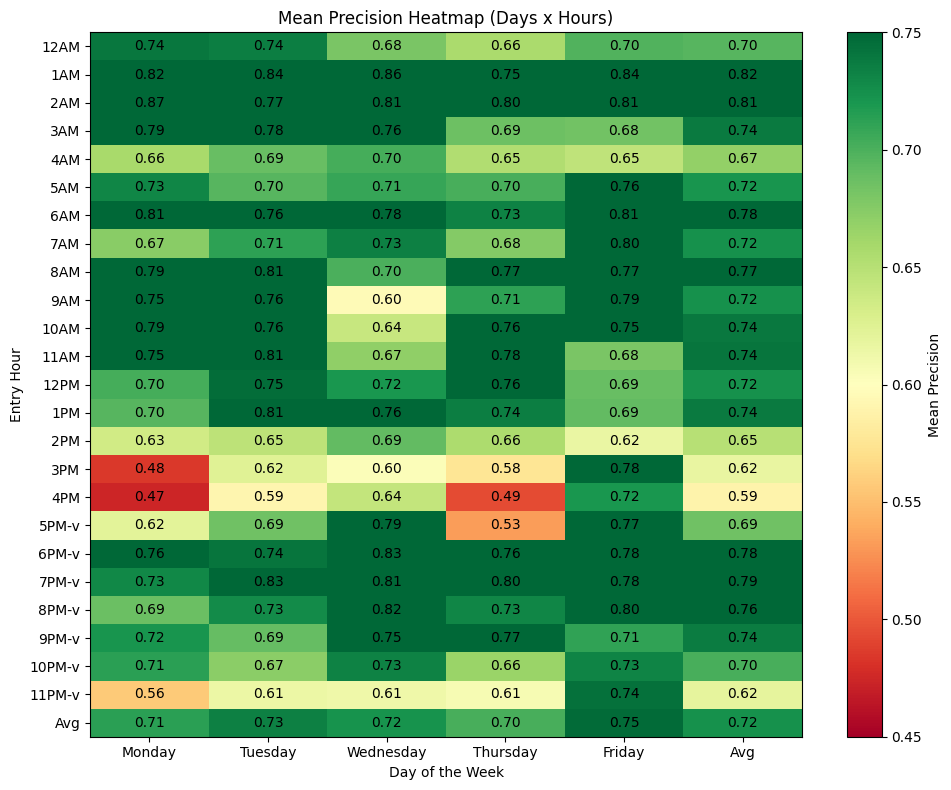

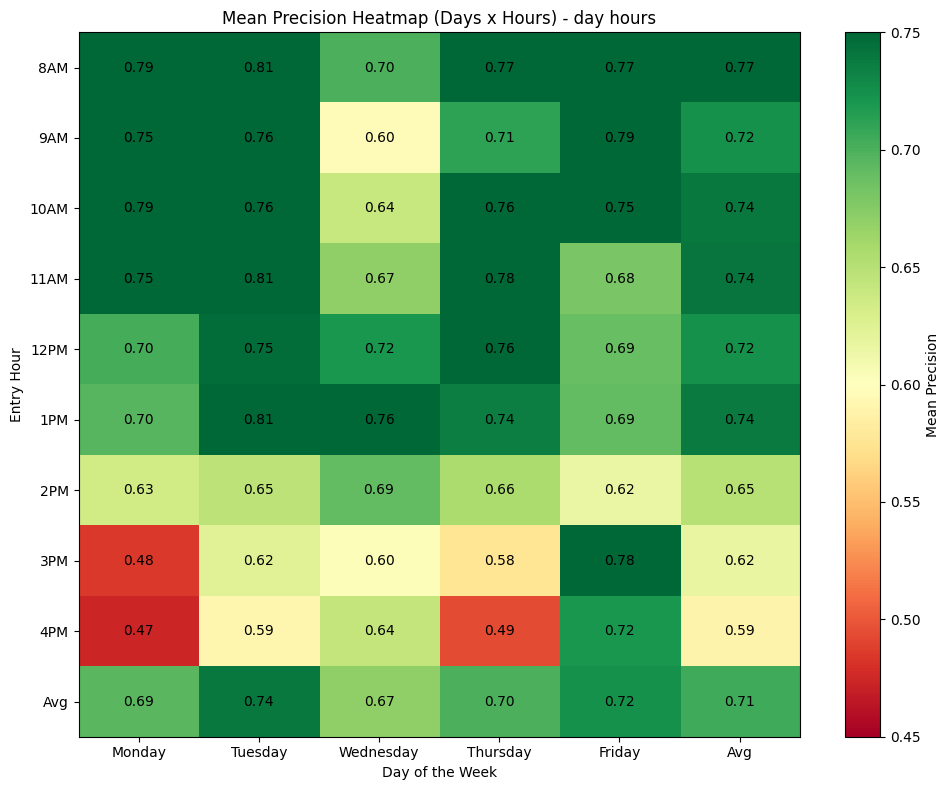

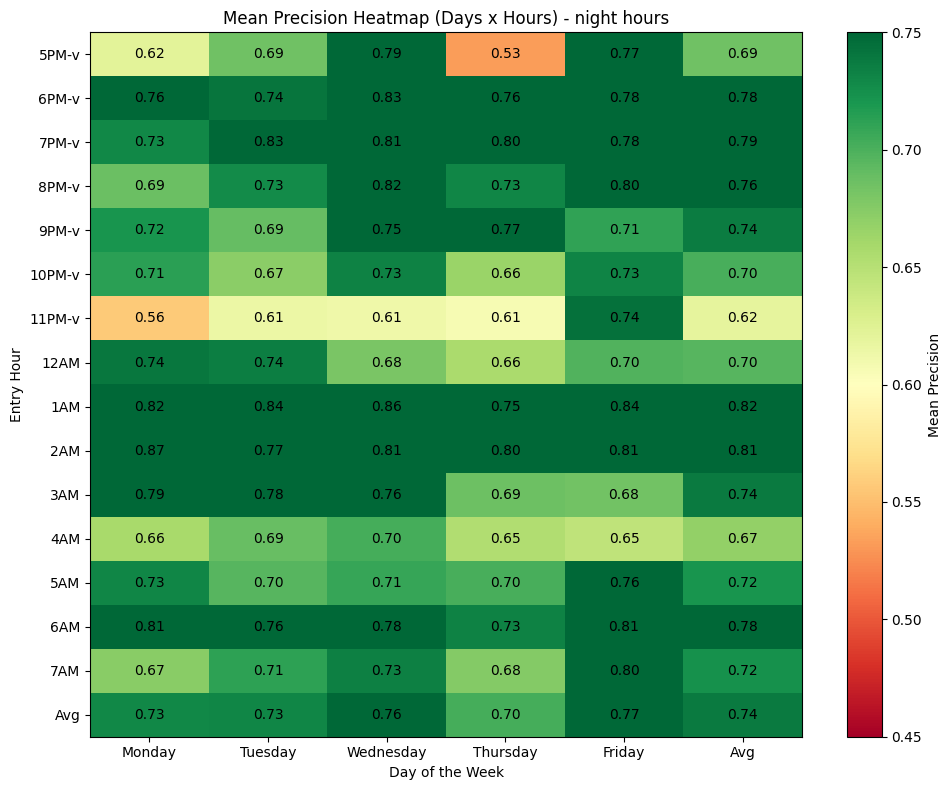

In [19]:
def process_row(**kwargs):
    """Process a single row, updating heatmaps with TP and FP values."""
    index, model_index, row, heatmaps, horizons, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()
    day = index.weekday()
    hour_index = index.hour
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")

    if day_hours_bool and (extracted_hour_label in day_hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in day_hours.items() if hour_label == extracted_hour_label)
    elif night_hours_bool and (extracted_hour_label in night_hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in night_hours.items() if hour_label == extracted_hour_label)
    elif all_hours_bool and (extracted_hour_label in hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in hours.items() if hour_label == extracted_hour_label)

    if (day in days.keys()): # Skip Saturday and Sunday because the market is closed (we applied a forward fill to fill the missing values but we don't want to evaluate them)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())): # Filter for day or night hours if triggered
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])

            for horizon_index in horizons:
                heatmaps[f"{day}_{hour_index}"]["TP"][horizon_index] += TP_list[horizon_index]
                heatmaps[f"{day}_{hour_index}"]["FP"][horizon_index] += FP_list[horizon_index]
kwargs = {}
precision(models=models, x_values=days, y_values=hours, x_labels = day_labels, y_labels = hour_labels, xlabel="Day of the Week", ylabel="Entry Hour", title="Mean Precision Heatmap (Days x Hours)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row, **kwargs)
precision(models=models, x_values=days, y_values=day_hours, x_labels = day_labels, y_labels = day_hours_labels, xlabel="Day of the Week", ylabel="Entry Hour", title="Mean Precision Heatmap (Days x Hours) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row, **kwargs)
precision(models=models, x_values=days, y_values=night_hours, x_labels = day_labels, y_labels = night_hours_labels, xlabel="Day of the Week", ylabel="Entry Hour", title="Mean Precision Heatmap (Days x Hours) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row, **kwargs)

### (Old and new version) Heatmap (Days x Hours)

In [ ]:
from typing import List

def precision_for_day_hour(models: List[str],):
    
    heatmaps = {f"{day}_{hour}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for day in days.keys() for hour in hours.keys()}

    # Create the matrix that will hold the TP and FP values for each day and hour
    n_hours = len(hours)
    n_days = len(days)
    tp_data = np.zeros((n_hours, n_days), dtype=float)
    fp_data = np.zeros((n_hours, n_days), dtype=float)

    for model in models.values():
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day = index.weekday() 
            hour = index.hour
            if day in days.keys(): # Skip the saturday and sunday because the market is closed (and we applied a forward fill to fill the missing values)
                
                # Retrieve the TP and FP values 
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                
                # Add them in the heatmaps dict
                for horizon_index in horizons:
                    heatmaps[f"{day}_{hour}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps[f"{day}_{hour}"]["FP"][horizon_index] += FP_list[horizon_index]
                
                TP_list = heatmaps[f"{day}_{hour}"]["TP"]
                FP_list = heatmaps[f"{day}_{hour}"]["FP"]
                tp_sum = sum(TP_list)
                fp_sum = sum(FP_list)

                tp_data[hour, day] = tp_sum
                fp_data[hour, day] = fp_sum

    base_data = np.zeros((n_hours, n_days), dtype=float)
    for hr in range(n_hours):
        for dy in range(n_days):
            total = tp_data[hr, dy] + fp_data[hr, dy]
            if total > 0:
                base_data[hr, dy] = tp_data[hr, dy] / total
            else:
                base_data[hr, dy] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=day_labels,
                        y_labels=hour_labels,
                        xlabel="Day of the Week",
                        ylabel="Entry Hour",
                        title="Mean Precision Heatmap (Days x Hours)")
    
precision_for_day_hour(models)

#### (Old version) Heatmap (days x hours) - day hours

In [ ]:
from typing import List

def precision_for_day_hour(models: List[str],):
    heatmaps_day_hour = {f"{day}_{hour}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for day in days.keys() for hour in day_hours.keys()}

    for model in models.values():
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day = index.weekday() 
            hour = index.hour
            if (hour in list(day_hours.keys())) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in range(3):
                    heatmaps_day_hour[f"{day}_{hour}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_day_hour[f"{day}_{hour}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_hours = len(day_hours)
    n_days = len(days)
    tp_data = np.zeros((n_hours, n_days), dtype=float)
    fp_data = np.zeros((n_hours, n_days), dtype=float)

    for day_index in days.keys():
        for hour_index, hour in enumerate(day_hours.keys()):
            TP_list = heatmaps_day_hour[f"{day_index}_{hour}"]["TP"]
            FP_list = heatmaps_day_hour[f"{day_index}_{hour}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[hour_index, day_index] = tp_sum
            fp_data[hour_index, day_index] = fp_sum


    base_data = np.zeros((n_hours, n_days), dtype=float)
    for hr in range(n_hours):
        for dy in range(n_days):
            total = tp_data[hr, dy] + fp_data[hr, dy]
            if total > 0:
                base_data[hr, dy] = tp_data[hr, dy] / total
            else:
                base_data[hr, dy] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=day_labels,
                        y_labels=day_hours_labels,
                        xlabel="Day of the Week",
                        ylabel="Entry Hour",
                        title="Mean Precision Heatmap (Days x Hours) - day hours")
    
precision_for_day_hour(models)


#### (Old version) Heatmap (days x hours) - night hours

In [ ]:
from typing import List

def precision_for_day_hour(models: List[str],):
    heatmaps_day_hour = {f"{day}_{hour}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for day in days.keys() for hour in night_hours.keys()}

    for model in models.values():
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day = index.weekday() 
            hour = index.hour
            if (hour in list(night_hours.keys())) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in range(3):
                    heatmaps_day_hour[f"{day}_{hour}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_day_hour[f"{day}_{hour}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_hours = len(night_hours)
    n_days = len(days)
    tp_data = np.zeros((n_hours, n_days), dtype=float)
    fp_data = np.zeros((n_hours, n_days), dtype=float)

    for day_index in days.keys():
        for hour_index, night_hour in enumerate(night_hours.keys()):
            TP_list = heatmaps_day_hour[f"{day_index}_{night_hour}"]["TP"]
            FP_list = heatmaps_day_hour[f"{day_index}_{night_hour}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[hour_index, day_index] = tp_sum
            fp_data[hour_index, day_index] = fp_sum

    base_data = np.zeros((n_hours, n_days), dtype=float)
    for hr in range(n_hours):
        for dy in range(n_days):
            total = tp_data[hr, dy] + fp_data[hr, dy]
            if total > 0:
                base_data[hr, dy] = tp_data[hr, dy] / total
            else:
                base_data[hr, dy] = 0.0
    
    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=day_labels,
                        y_labels=night_hours_labels,
                        xlabel="Day of the Week",
                        ylabel="Entry Hour",
                        title="Mean Precision Heatmap (Days x Hours) - night hours")
    
precision_for_day_hour(models)


### (Old and new version) Heatmap (Models x Hours)

#### New version

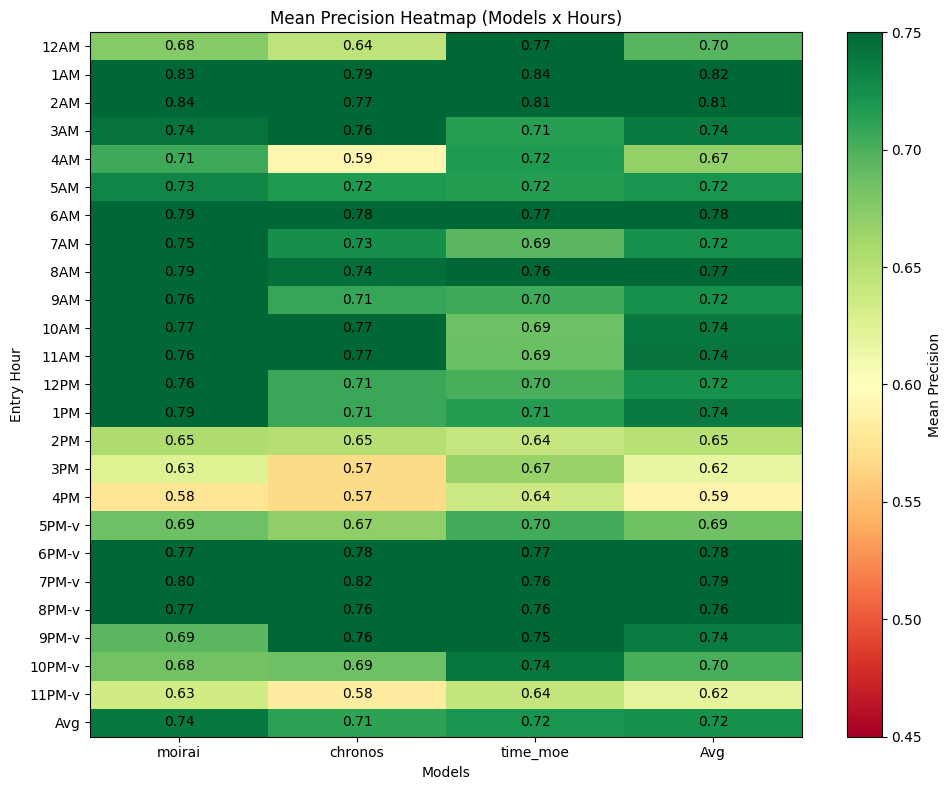

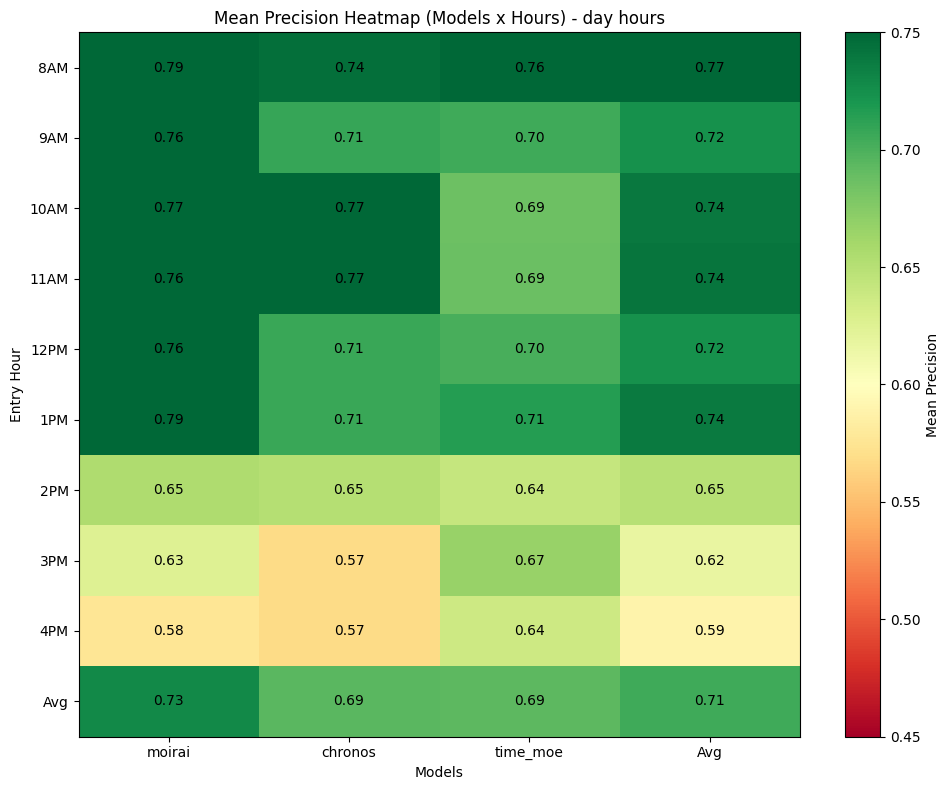

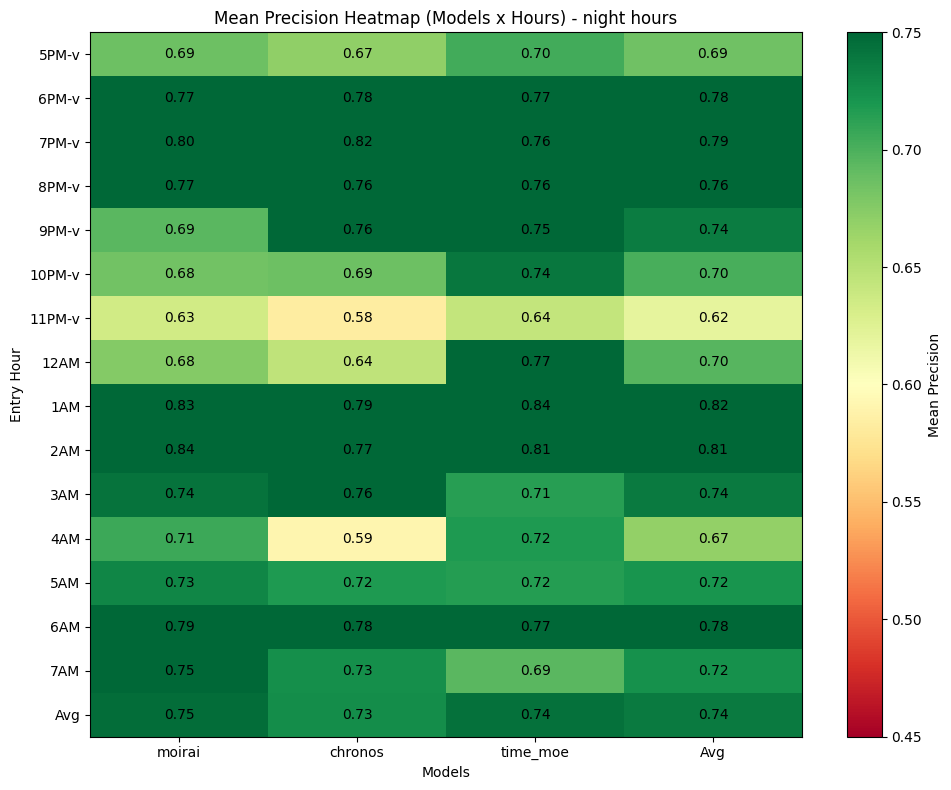

In [20]:
def process_row(**kwargs):
    """Process a single row, updating heatmaps with TP and FP values."""
    index, model_index, row, heatmaps, horizons, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()
    hour_index = index.hour
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")
    day = index.weekday()

    if day_hours_bool and (extracted_hour_label in day_hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in day_hours.items() if hour_label == extracted_hour_label)
    elif night_hours_bool and (extracted_hour_label in night_hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in night_hours.items() if hour_label == extracted_hour_label)
    elif all_hours_bool and (extracted_hour_label in hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in hours.items() if hour_label == extracted_hour_label)

    if (day in days.keys()):
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())): # Filter for day or night hours if triggered 
            TP_List = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            for horizon_index in range(len(horizons)):
                heatmaps[f"{model_index}_{hour_index}"]["TP"][horizon_index] += TP_List[horizon_index]
                heatmaps[f"{model_index}_{hour_index}"]["FP"][horizon_index] += FP_list[horizon_index]

kwargs = {}
precision(models=models, x_values=models, y_values=hours, x_labels = list(models.values()), y_labels = hour_labels, xlabel="Models", ylabel="Entry Hour", title="Mean Precision Heatmap (Models x Hours)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row, **kwargs)
precision(models=models, x_values=models, y_values=day_hours, x_labels = list(models.values()), y_labels = day_hours_labels, xlabel="Models", ylabel="Entry Hour", title="Mean Precision Heatmap (Models x Hours) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row, **kwargs)
precision(models=models, x_values=models, y_values=night_hours, x_labels = list(models.values()), y_labels = night_hours_labels, xlabel="Models", ylabel="Entry Hour", title="Mean Precision Heatmap (Models x Hours) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row, **kwargs)

#### Old version

In [ ]:
def precision_for_model_hour():
    heatmaps_model_hour = {f"{model}_{hour}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in list(models.values()) for hour in hours.keys()}
    for model in list(models.values()):
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            hour = index.hour
            day = index.weekday()
            if day in days.keys(): 
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_List = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in range(len(horizons)):
                    heatmaps_model_hour[f"{model}_{hour}"]["TP"][horizon_index] += TP_List[horizon_index]
                    heatmaps_model_hour[f"{model}_{hour}"]["FP"][horizon_index] += FP_list[horizon_index]


    n_models = len(models)
    n_hours = len(hours)
    tp_data = np.zeros((n_hours, n_models), dtype=float)
    fp_data = np.zeros((n_hours, n_models), dtype=float)

    for model_index, model in models.items():
        for hour_index in hours.keys():
            TP_list = heatmaps_model_hour[f"{model}_{hour_index}"]["TP"]
            FP_list = heatmaps_model_hour[f"{model}_{hour_index}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[hour_index, model_index] = tp_sum
            fp_data[hour_index, model_index] = fp_sum

    base_data = np.zeros((n_hours, len(models)), dtype=float)

    for hour_index in hours.keys():
        for model_index, model in models.items():
            total = tp_data[hour_index, model_index] + fp_data[hour_index, model_index]
            if total > 0:
                base_data[hour_index, model_index] = tp_data[hour_index, model_index] / total
            else:
                base_data[hour_index, model_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=list(models.values()),
                        y_labels=hour_labels,
                        xlabel="Models",
                        ylabel="Entry Hour",
                        title="Mean Precision Heatmap (Models x Hours)")
    
precision_for_model_hour()


#### (Old version) Heatmap (Models x hours) - day hours

In [ ]:
def precision_for_model_hour():

    heatmaps_model_hour = {f"{model}_{hour}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models for hour in day_hours.keys()}

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            hour = index.hour
            day = index.weekday()
            if (hour in day_hours.keys()) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in range(3):
                    heatmaps_model_hour[f"{model}_{hour}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_hour[f"{model}_{hour}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_models = len(models)
    n_hours = len(day_hours)
    tp_data = np.zeros((n_hours, n_models), dtype=float)
    fp_data = np.zeros((n_hours, n_models), dtype=float)

    for model_index, model in enumerate(models):
        for day_hour_index, hour in enumerate(day_hours.keys()):
            TP_list = heatmaps_model_hour[f"{model}_{hour}"]["TP"]
            FP_list = heatmaps_model_hour[f"{model}_{hour}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[day_hour_index, model_index] = tp_sum
            fp_data[day_hour_index, model_index] = fp_sum


    base_data = np.zeros((n_hours, len(models)), dtype=float)
    for day_hour_index, hour in enumerate(day_hours.keys()):
        for model_index, model in enumerate(models):
            total = tp_data[day_hour_index, model_index] + fp_data[day_hour_index, model_index]
            if total > 0:
                base_data[day_hour_index, model_index] = tp_data[day_hour_index, model_index] / total
            else:
                base_data[day_hour_index, model_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)   

    plot_extended_heatmap(extended_data, 
                        x_labels=models,
                        y_labels=day_hours_labels,
                        xlabel="Models",
                        ylabel="Entry Hour",
                        title="Mean Precision Heatmap (Models x Hours) - day hours")
    
precision_for_model_hour()


#### (Old version) Heatmap (Models x hours) - night hours

In [ ]:
def precision_for_model_hour():

    heatmaps_model_hour = {f"{model}_{hour}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models for hour in night_hours.keys()}

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            hour = index.hour
            day = index.weekday()
            if (hour in night_hours.keys()) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in range(3):
                    heatmaps_model_hour[f"{model}_{hour}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_hour[f"{model}_{hour}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_models = len(models)
    n_hours = len(night_hours)
    tp_data = np.zeros((n_hours, n_models), dtype=float)
    fp_data = np.zeros((n_hours, n_models), dtype=float)

    for model_index, model in enumerate(models):
        for night_hour_index, hour in enumerate(night_hours.keys()):
            TP_list = heatmaps_model_hour[f"{model}_{hour}"]["TP"]
            FP_list = heatmaps_model_hour[f"{model}_{hour}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[night_hour_index, model_index] = tp_sum
            fp_data[night_hour_index, model_index] = fp_sum

    base_data = np.zeros((n_hours, len(models)), dtype=float)
    for night_hour_index, hour in enumerate(night_hours.keys()):
        for model_index, model in enumerate(models):
            total = tp_data[night_hour_index, model_index] + fp_data[night_hour_index, model_index]
            if total > 0:
                base_data[night_hour_index, model_index] = tp_data[night_hour_index, model_index] / total
            else:
                base_data[night_hour_index, model_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=models,
                        y_labels=night_hours_labels,
                        xlabel="Models",
                        ylabel="Entry Hour",
                        title="Mean Precision Heatmap (Models x Hours) - night hours")
    
precision_for_model_hour()

### Heatmap (Models x Horizon)

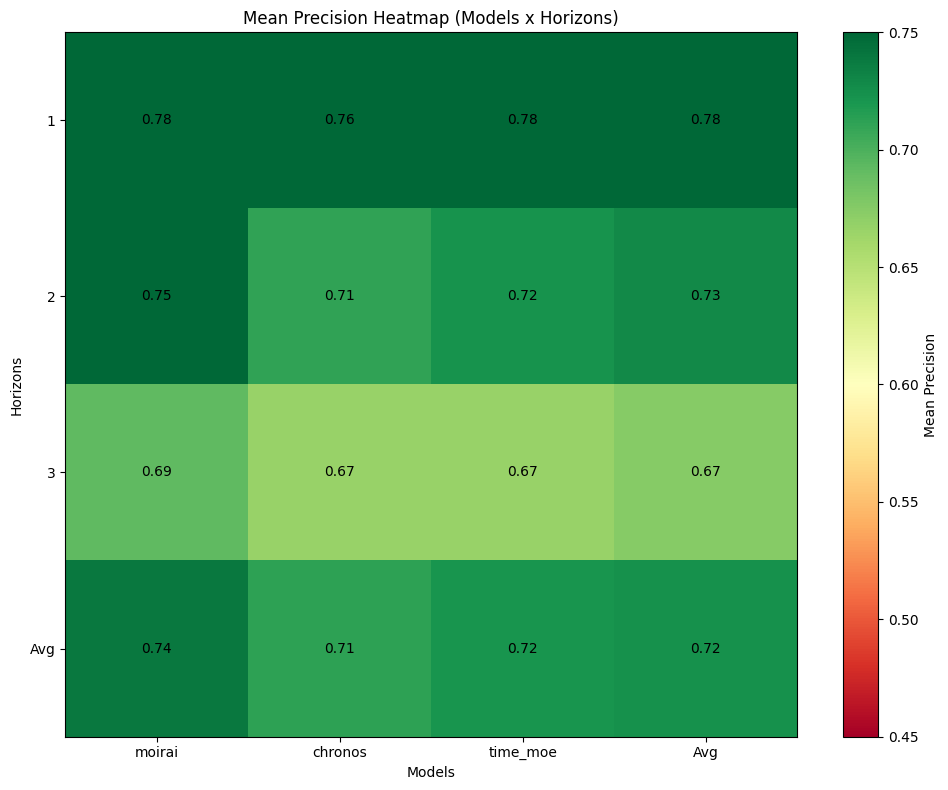

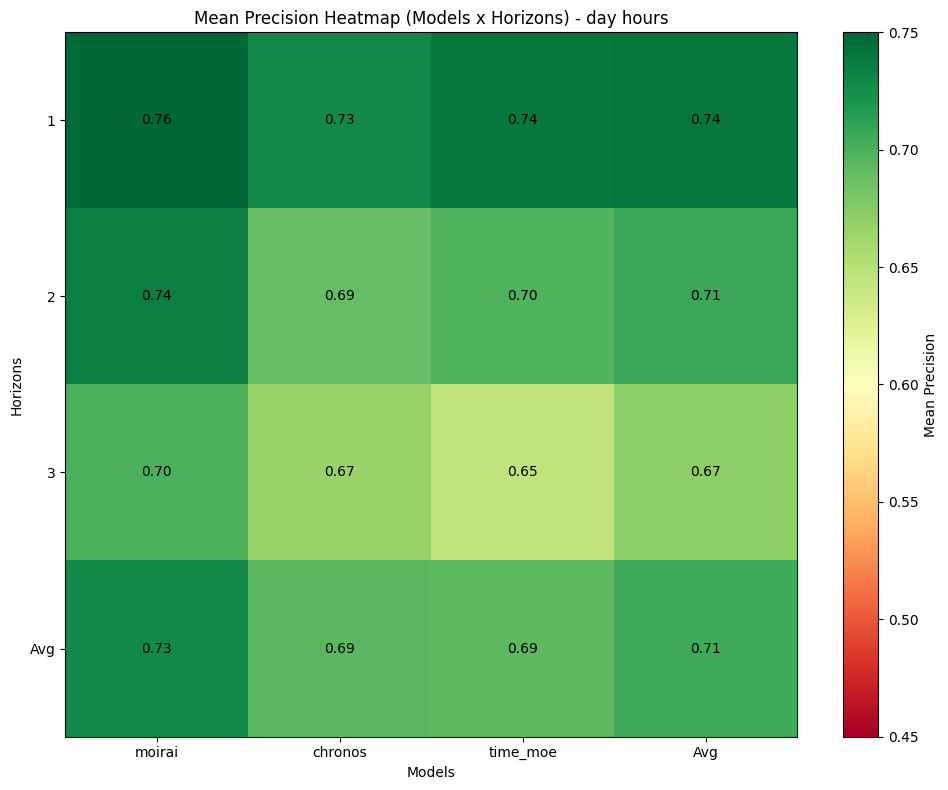

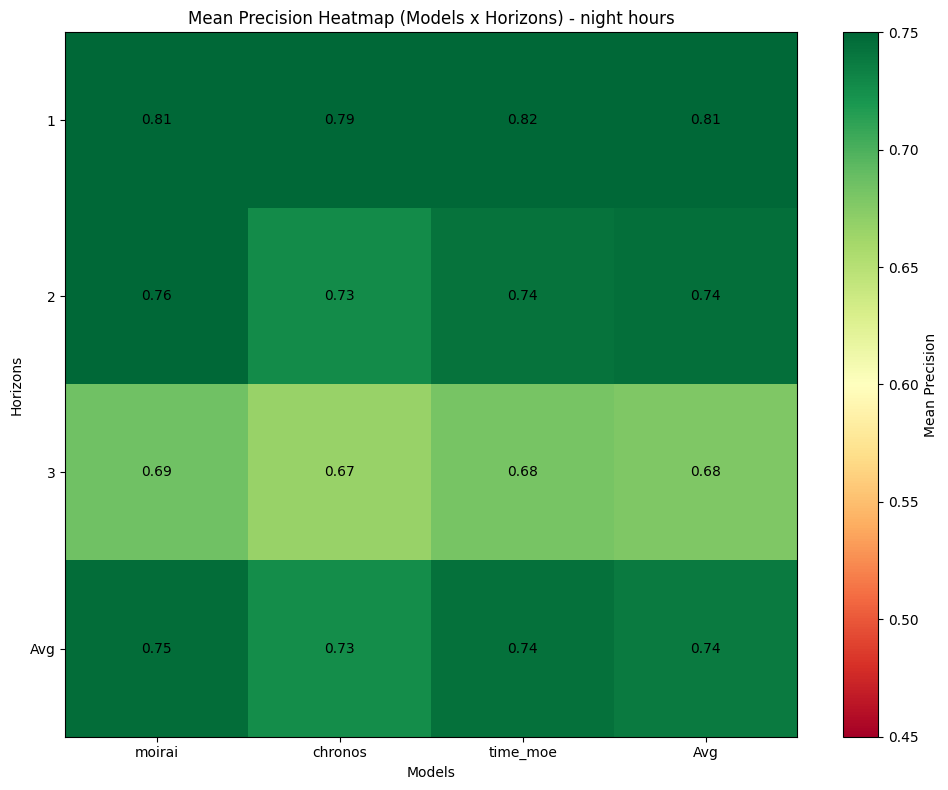

In [24]:
def process_row(**kwargs):
    """Process a single row, updating heatmaps with TP and FP values."""
    index, model_index, row, heatmaps, horizons, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()
    hour_index = index.hour
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")
    day = index.weekday()

    if (day in days.keys()):
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())): # Filter for day or night hours if triggered 
            TP_List = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            for horizon_index in range(len(horizons)):
                heatmaps[f"{model_index}_{horizon_index }"]["TP"][horizon_index] += TP_List[horizon_index]
                heatmaps[f"{model_index}_{horizon_index }"]["FP"][horizon_index] += FP_list[horizon_index]

kwargs = {}
precision(models=models, x_values=models, y_values=horizons, x_labels = list(models.values()), y_labels = horizons_label, xlabel="Models", ylabel="Horizons", title="Mean Precision Heatmap (Models x Horizons)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row, **kwargs)
precision(models=models, x_values=models, y_values=horizons, x_labels = list(models.values()), y_labels = horizons_label, xlabel="Models", ylabel="Horizons", title="Mean Precision Heatmap (Models x Horizons) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row, **kwargs)
precision(models=models, x_values=models, y_values=horizons, x_labels = list(models.values()), y_labels = horizons_label, xlabel="Models", ylabel="Horizons", title="Mean Precision Heatmap (Models x Horizons) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row, **kwargs)

#### Old version 

In [ ]:
def precision_for_model_horizon():

    heatmaps_model_horizon = {f"{model}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models}
    # base_data = np.zeros((len(horizons), len(models))) # Create the base 2D array (Days x Hours)

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            # compute the precision for each row and store it in the good entry in the dictionary
            day = index.weekday()
            if day in days.keys(): 
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in horizons:
                    heatmaps_model_horizon[f"{model}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_horizon[f"{model}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_horizon = len(horizons)
    n_models = len(models)
    tp_data = np.zeros((n_horizon, n_models), dtype=float)
    fp_data = np.zeros((n_horizon, n_models), dtype=float)

    for model_index, model in enumerate(models):
        for horizon_index in horizons:
            # Sum across the 3 horizons:
            TP_list = heatmaps_model_horizon[model]["TP"]
            FP_list = heatmaps_model_horizon[model]["FP"]
            tp_sum = TP_list[horizon_index]
            fp_sum = FP_list[horizon_index]

            tp_data[horizon_index, model_index] = tp_sum
            fp_data[horizon_index, model_index] = fp_sum
    
    base_data = np.zeros((n_horizon, n_models), dtype=float)
    for hr in range(n_horizon):
        for model_index, model in enumerate(models):
            total = tp_data[hr, model_index] + fp_data[hr, model_index]
            if total > 0:
                base_data[hr, model_index] = tp_data[hr, model_index] / total
            else:
                base_data[hr, model_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=models,
                        y_labels=horizons_label,
                        xlabel="Models",
                        ylabel="Horizons",
                        title="Mean Precision Heatmap (Models x Horizons)")
    
precision_for_model_horizon()


#### (Old version) Heatmap (Models x horizon) - day hours

In [ ]:
def precision_for_model_horizon():

    heatmaps_model_horizon = {f"{model}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models}

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            hour = index.hour
            day = index.weekday()
            if (hour in day_hours.keys()) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in horizons:
                    heatmaps_model_horizon[f"{model}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_horizon[f"{model}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_models = len(models)
    n_horizon = len(horizons)
    tp_data = np.zeros((n_horizon, n_models), dtype=float)
    fp_data = np.zeros((n_horizon, n_models), dtype=float)

    for model_index, model in enumerate(models):
        for horizon_index in horizons:
            # Sum across the 3 horizons:
            TP_list = heatmaps_model_horizon[model]["TP"]
            FP_list = heatmaps_model_horizon[model]["FP"]
            tp_sum = TP_list[horizon_index]
            fp_sum = FP_list[horizon_index]

            tp_data[horizon_index, model_index] = tp_sum
            fp_data[horizon_index, model_index] = fp_sum


    base_data = np.zeros((n_horizon, n_models), dtype=float)
    for hr in range(n_horizon):
        for model_index, model in enumerate(models):
            total = tp_data[hr, model_index] + fp_data[hr, model_index]
            if total > 0:
                base_data[hr, model_index] = tp_data[hr, model_index] / total
            else:
                base_data[hr, model_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=models,
                        y_labels=horizons_label,
                        xlabel="Models",
                        ylabel="Horizons",
                        title="Mean Precision Heatmap (Models x Horizons) - day hours")
    
precision_for_model_horizon()


#### (Old version) Heatmap (Models x horizon) - night hours

In [ ]:
def precision_for_model_horizon():

    heatmaps_model_horizon = {f"{model}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models}

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            hour = index.hour
            day = index.weekday()
            if (hour in night_hours.keys()) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in horizons:
                    heatmaps_model_horizon[f"{model}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_horizon[f"{model}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_models = len(models)
    n_horizon = len(horizons)
    tp_data = np.zeros((n_horizon, n_models), dtype=float)
    fp_data = np.zeros((n_horizon, n_models), dtype=float)

    for model_index, model in enumerate(models):
        for horizon_index in horizons:
            # Sum across the 3 horizons:
            TP_list = heatmaps_model_horizon[model]["TP"]
            FP_list = heatmaps_model_horizon[model]["FP"]
            tp_sum = TP_list[horizon_index]
            fp_sum = FP_list[horizon_index]

            tp_data[horizon_index, model_index] = tp_sum
            fp_data[horizon_index, model_index] = fp_sum
    
    base_data = np.zeros((n_horizon, n_models), dtype=float)
    for hr in range(n_horizon):
        for model_index, model in enumerate(models):
            total = tp_data[hr, model_index] + fp_data[hr, model_index]
            if total > 0:
                base_data[hr, model_index] = tp_data[hr, model_index] / total
            else:
                base_data[hr, model_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=models,
                        y_labels=horizons_label,
                        xlabel="Models",
                        ylabel="Horizons",
                        title="Mean Precision Heatmap (Models x Horizons) - night hours")
    
precision_for_model_horizon()


### Heatmap (Days x Models)

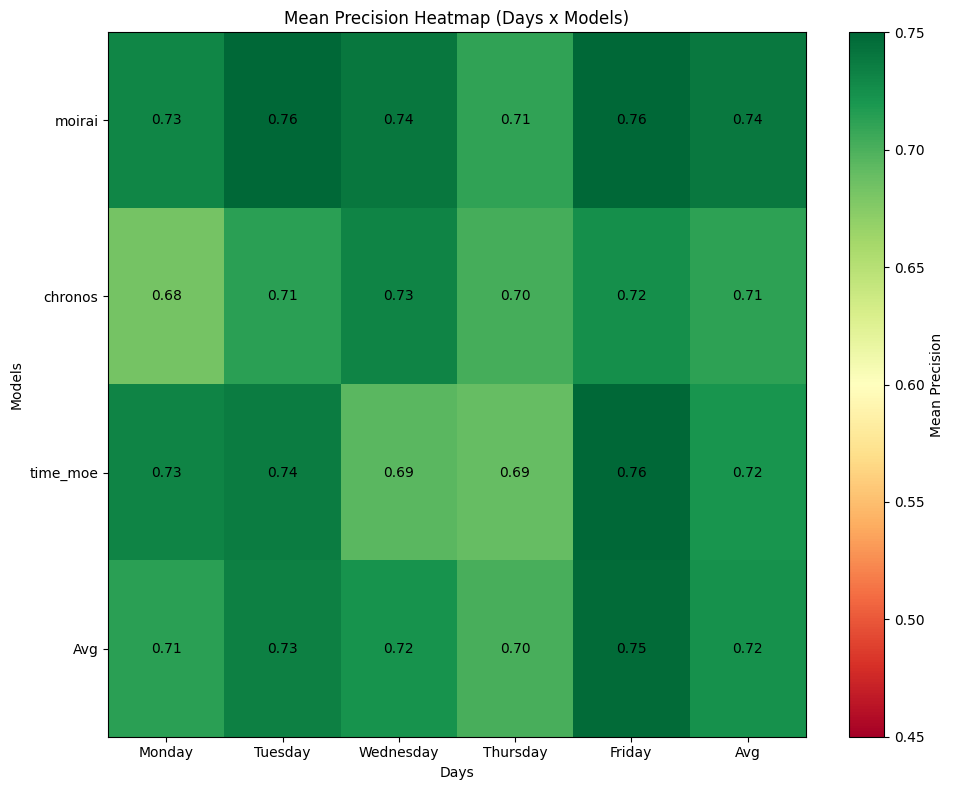

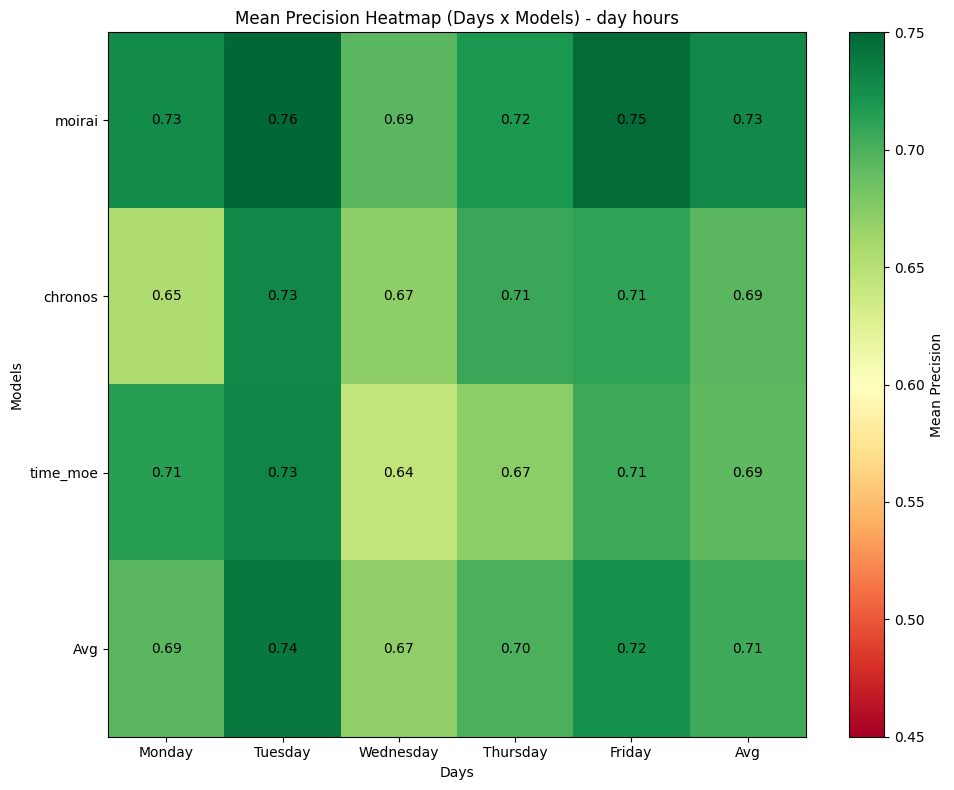

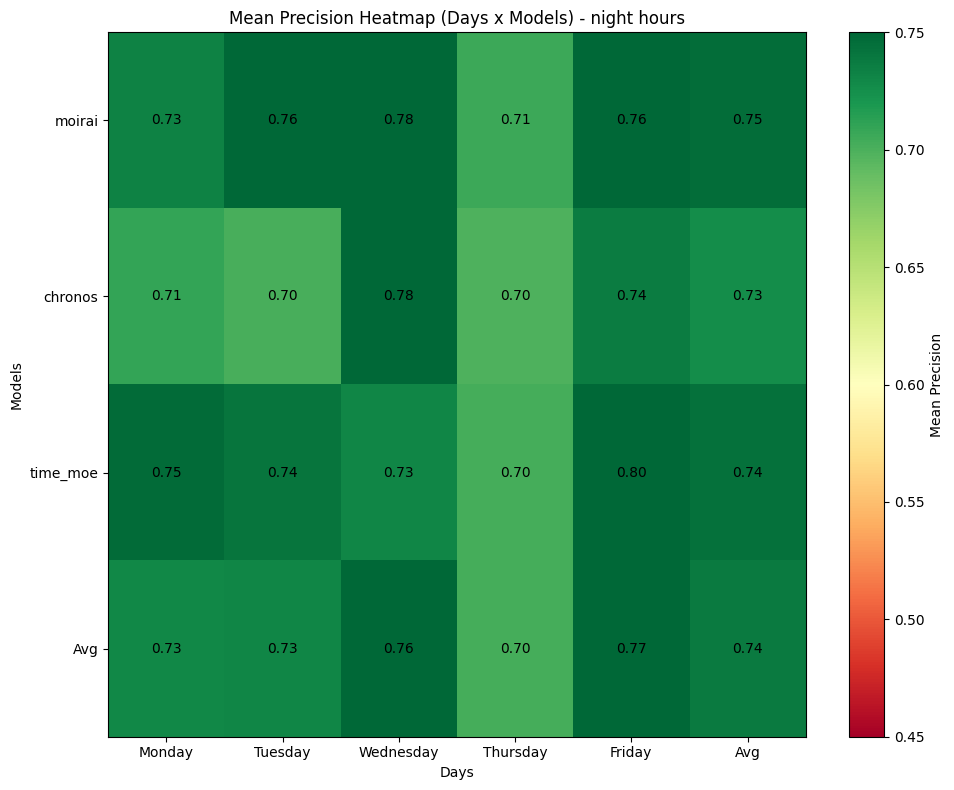

In [26]:
def process_row(**kwargs):
    """Process a single row, updating heatmaps with TP and FP values."""
    index, model_index, row, heatmaps, horizons, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()
    hour_index = index.hour
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")
    day_index = index.weekday()

    if (day_index in days.keys()):
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())): # Filter for day or night hours if triggered 
            TP_List = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            for horizon_index in range(len(horizons)):
                heatmaps[f"{day_index}_{model_index}"]["TP"][horizon_index] += TP_List[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["FP"][horizon_index] += FP_list[horizon_index]

kwargs = {}
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = list(models.values()), xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row, **kwargs)
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = list(models.values()), xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row, **kwargs)
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = list(models.values()), xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row, **kwargs)

#### Old version 

In [ ]:
def precision_for_model_day():
    heatmaps_model_day = {
        f"{day}_{model}": {"TP": [0] * len(horizons), "FP": [0] * len(horizons)}
        for model in models for day in days.keys()
    }

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day = index.weekday()
            if day in days.keys():
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                for horizon_index in horizons:
                    heatmaps_model_day[f"{day}_{model}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_day[f"{day}_{model}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_days = len(days)
    n_models = len(models)
    tp_data = np.zeros((n_models, n_days), dtype=float)  # (Models, Days)
    fp_data = np.zeros((n_models, n_days), dtype=float)  # (Models, Days)

    for day_index, day in days.items():
        for model_index, model in enumerate(models):
            TP_list = heatmaps_model_day[f"{day_index}_{model}"]["TP"]
            FP_list = heatmaps_model_day[f"{day_index}_{model}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[model_index, day_index] = tp_sum
            fp_data[model_index, day_index] = fp_sum

    base_data = np.zeros((n_models, n_days), dtype=float)
    for model_index in range(n_models):
        for day_index in range(n_days):
            total = tp_data[model_index, day_index] + fp_data[model_index, day_index]
            if total > 0:
                base_data[model_index, day_index] = tp_data[model_index, day_index] / total
            else:
                base_data[model_index, day_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                          x_labels=day_labels,
                          y_labels=models,
                          xlabel="Days", 
                          ylabel="Models",
                          title="Mean Precision Heatmap (Models x Days)")

precision_for_model_day()

#### (Old version) Heatmap (Models x days) - day hours

In [ ]:
def precision_for_model_day():
    # the order is reversed compared to the previous function but it's consistent
    heatmaps_model_day = {f"{day}_{model}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models for day in days.keys()}

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day = index.weekday() 
            hour = index.hour
            if (hour in day_hours.keys()) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in horizons:
                    heatmaps_model_day[f"{day}_{model}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_day[f"{day}_{model}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_days = len(days)
    n_models = len(models)
    tp_data = np.zeros((n_models, n_days), dtype=float)
    fp_data = np.zeros((n_models, n_days), dtype=float)


    for day_index, day in days.items():
        for model_index, model in enumerate(models):
            TP_list = heatmaps_model_day[f"{day_index}_{model}"]["TP"]
            FP_list = heatmaps_model_day[f"{day_index}_{model}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[model_index, day_index] = tp_sum
            fp_data[model_index, day_index] = fp_sum

    base_data = np.zeros((n_models, n_days), dtype=float)
    for model_index in range(n_models):
        for day_index in range(n_days):
            total = tp_data[model_index, day_index] + fp_data[model_index, day_index]
            if total > 0:
                base_data[model_index, day_index] = tp_data[model_index, day_index] / total
            else:
                base_data[model_index, day_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=day_labels,
                        y_labels=models,
                        xlabel="Models",
                        ylabel="Days",
                        title="Mean Precision Heatmap (Models x Days) - day hours")
    
precision_for_model_day()

#### (Old version) Heatmap (Models x days) - night hours

In [ ]:
def precision_for_model_day():
    # the order is reversed compared to the previous function but it's consistent
    heatmaps_model_day = {f"{day}_{model}": {"TP": [0]*len(horizons), "FP": [0]*len(horizons)} for model in models for day in days.keys()}

    for model in models:
        df = pd.read_csv(f"../future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

        first_predicted_row = 383
        last_predicted_row = len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day = index.weekday() 
            hour = index.hour
            if (hour in night_hours.keys()) and (day in days.keys()):
                # compute the precision for each row and store it in the good entry in the dictionary
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                # add this value in the corresponding dict
                for horizon_index in horizons:
                    heatmaps_model_day[f"{day}_{model}"]["TP"][horizon_index] += TP_list[horizon_index]
                    heatmaps_model_day[f"{day}_{model}"]["FP"][horizon_index] += FP_list[horizon_index]

    n_days = len(days)
    n_models = len(models)
    tp_data = np.zeros((n_models, n_days), dtype=float)
    fp_data = np.zeros((n_models, n_days), dtype=float)


    for day_index, day in days.items():
        for model_index, model in enumerate(models):
            TP_list = heatmaps_model_day[f"{day_index}_{model}"]["TP"]
            FP_list = heatmaps_model_day[f"{day_index}_{model}"]["FP"]
            tp_sum = sum(TP_list)
            fp_sum = sum(FP_list)

            tp_data[model_index, day_index] = tp_sum
            fp_data[model_index, day_index] = fp_sum

    base_data = np.zeros((n_models, n_days), dtype=float)
    for model_index in range(n_models):
        for day_index in range(n_days):
            total = tp_data[model_index, day_index] + fp_data[model_index, day_index]
            if total > 0:
                base_data[model_index, day_index] = tp_data[model_index, day_index] / total
            else:
                base_data[model_index, day_index] = 0.0

    extended_data = create_extended_heatmap_data(base_data, tp_data, fp_data)

    plot_extended_heatmap(extended_data, 
                        x_labels=day_labels,
                        y_labels=models,
                        xlabel="Models",
                        ylabel="Days",
                        title="Mean Precision Heatmap (Models x Days) - night hours")
    
precision_for_model_day()

### Heatmap (Months x Quarters) - TODO corriger ça

In [ ]:
##############################################

# All models and full period

##############################################
 
import pandas as pd

# Define start and end dates
start_date = "2023-03-01"
end_date = "2024-12-12" # we remove the last day because it was tedious to handle because of out-of-bound error

# Generate a range of dates
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# store all results per month
TP_sum_month = [0 for _ in range(12)]
TN_sum_month = [0 for _ in range(12)]
FP_sum_month = [0 for _ in range(12)]
FN_sum_month = [0 for _ in range(12)]

for date in date_range:
    date_str = date.strftime("%Y-%m-%d")
    month = date.month - 1 # month is zero-based
    for model in models:
        (TP, TN, FN, FP) = precision_per_day(file_path=f"../future_data/es_future_final_{model}.csv", date=date_str)
        # We sum the prediction for all horizons when we do sum(TP), sum(TN), sum(FN), sum(FP)
        TP_sum_month[month] += sum(TP) 
        TN_sum_month[month] += sum(TN)
        FN_sum_month[month] += sum(FN)
        FP_sum_month[month] += sum(FP)

        print("TP: ", TP_sum_month, "TN: ", TN_sum_month, "FP: ", FP_sum_month, "FN: ", FN_sum_month)

In [ ]:
# TP_sum_month = [1292, 1438, 3141, 2719, 2637, 2897, 3035, 3356, 2909, 2900, 2704, 1980]
# TN_sum_month = [2766, 1758, 3832, 4556, 4339, 3482, 4368, 4077, 4173, 4317, 4505, 2732]
# FN_sum_month = [2119, 2639, 5124, 4523, 5262, 5551, 4678, 4459, 4423, 4933, 4406, 3876]
# FP_sum_month = [441, 339, 1007, 1021, 971, 817, 1134, 1344, 1281, 1065, 1216, 529]

heatmaps_month_quarter = dict()
for month_index in range(12):
    quarter = (month_index // 3) + 1
    precision = TP_sum_month[month_index] / (TP_sum_month[month_index] + FP_sum_month[month_index])
    heatmaps_month_quarter[f"{month_index}_{quarter}"] = precision

print(heatmaps_month_quarter)

In [ ]:
import numpy as np

base_data = np.zeros((3, len(quarters)))
for month_index in range(12):
    quarter = (month_index) // 3 + 1
    row_pos = (month_index) % 3
    col_pos = quarter - 1
    precision = heatmaps_month_quarter[f"{month_index}_{quarter}"]
    base_data[row_pos, col_pos] = precision

x_labels = quarters_label
y_labels = ["Month 1", "Month 2", "Month 3"]

plot_extended_heatmap(
    create_extended_heatmap_data(base_data), 
    x_labels=x_labels,
    y_labels=y_labels,
    xlabel="Quarters",
    ylabel="Month-Position in Quarter",
    title="Mean Precision Heatmap (Months x Quarters)"
)


# SHAP

In [ ]:
import pandas as pd
import ast

features = ["ATR_10", "RSI", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]

data = pd.read_csv("es_future_final_time_moe.csv", parse_dates = True, index_col = 0)
data.dropna(inplace=True)

# Assuming your DataFrame is named 'data' and the column with the lists is named 'score'

# Step 1: Convert the string representation of lists into actual lists
data['score'] = data['score'].apply(ast.literal_eval)
data['APE'] = data['APE'].apply(ast.literal_eval)
data['SIGN'] = data['SIGN'].apply(ast.literal_eval)


# Step 2: Create a DataFrame from the lists and expand the columns
score_df = pd.DataFrame(data['score'].tolist(), index=data.index)
ape_df = pd.DataFrame(data['APE'].tolist(), index=data.index)
sign_df = pd.DataFrame(data['SIGN'].tolist(), index=data.index)

# Step 3: Rename the columns to SCORE_1, SCORE_2, ..., SCORE_12
score_df.columns = [f'SCORE_{i+1}' for i in range(score_df.shape[1])]
ape_df.columns = [f'APE_{i+1}' for i in range(ape_df.shape[1])]
sign_df.columns = [f'SIGN_{i+1}' for i in range(sign_df.shape[1])]


# Step 4: (Optional) Concatenate this new DataFrame with the original DataFrame
data = pd.concat([data, score_df, ape_df, sign_df], axis=1)
data

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def beeswarm_plot(df, target, features):
    """
    Beeswarm Plot with TreeSHAP
    Args:
        df (pd.DataFrame): Input DataFrame containing features and target
        target (str): Name of the target column
        features (list): List of feature column names

    Returns:
        shap_values: Computed SHAP values
    """
    # Split data into features and target
    X = df[features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the RandomForestRegressor
    model = lgb.LGBMRegressor()
    model.fit(X, y)
    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)  # Preferred API in newer versions

    # Global importance bar plot
    shap.summary_plot(shap_values.values, X_test, plot_type="bar")
    plt.show()

    # Beeswarm plot
    shap.summary_plot(shap_values.values, X_test)
    plt.show()

    return shap_values


In [ ]:
df = data.copy()
df.dropna(inplace=True)

In [ ]:
new_df = df[df["APE_1"] < df["APE_1"].quantile(0.99)]
values = beeswarm_plot(new_df, "APE_1", features)

In [ ]:
new_df = df[df["APE_1"] < df["APE_1"].quantile(0.95)]
values = beeswarm_plot(new_df, "APE_1", features)

In [ ]:
new_df = df[df["APE_2"] < df["APE_2"].quantile(0.99)]
values = beeswarm_plot(new_df, "APE_2", features)

In [ ]:
new_df = df[df["APE_2"] < df["APE_2"].quantile(0.95)]
values = beeswarm_plot(new_df, "APE_2", features)

In [ ]:
new_df = df[df["APE_3"] < df["APE_3"].quantile(0.99)]
values = beeswarm_plot(new_df, "APE_3", features)

In [ ]:
new_df = df[df["APE_3"] < df["APE_3"].quantile(0.95)]
values = beeswarm_plot(new_df, "APE_3", features)

In [ ]:
df[features].describe()

# Discarding features

In [ ]:
df = pd.concat([precision("es_future_final_moirai.csv").T, precision("es_future_final_moirai_moe.csv").T, precision("es_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - All points - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("es_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("es_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("es_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.3).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]

df.plot(
    title="ES Future - Discarding Q3 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("es_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("es_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("es_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.5).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - Discarding Q5 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("es_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("es_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("es_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.8).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - Discarding Q8 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

In [ ]:
df = pd.concat([precision("gc_future_final_moirai.csv").T, precision("gc_future_final_moirai_moe.csv").T, precision("gc_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - All points - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("gc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("gc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.3).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - Discarding Q3 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("gc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("gc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.5).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - Discarding Q5 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("gc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("gc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.8).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - Discarding Q8 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

In [ ]:
df = pd.concat([precision("btc_future_final_moirai.csv").T, precision("btc_future_final_moirai.csv").T, precision("btc_future_final_moirai.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - All points - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("btc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("btc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.3).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - Discarding Q3 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("btc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("btc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.5).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - Discarding Q5 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("btc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("btc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.8).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - Discarding Q8 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

# Buckets

### Main function

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np


def buckets(file_path, target = "Close_denoised_standardized", horizon = 12, threshold_column=None):
    df = pd.read_csv(file_path, parse_dates = True, index_col = 0)
    df["DistanceToEMA60"] = df["DistanceToEMM60"]
    df.dropna(inplace=True)

    def atr(target, horizon = 12, threshold_column = None, q1 = 0, q2 = 0.1):
        i = 384
        TP = [0 for k in range(horizon)]
        TN = [0 for k in range(horizon)]
        FP = [0 for k in range(horizon)]
        FN = [0 for k in range(horizon)]
        if threshold_column is not None:
            low_threshold = df[threshold_column].quantile(q1)
            high_threshold = df[threshold_column].quantile(q2)

        # -13 is used to avoid predicting the next 12 hours for our last data point.
        # Our last data point represents an hour. Starting the prediction at this hour is not possible because we could not verify if the prediction is correct or not. 
        while i < len(df)-13:
            try:
                index = df.index[i]
                # Filter out all the rows that have a value in their threshold_column that is above the high_threshold or below the low_threshold.
                if threshold_column is not None and (df[threshold_column].iloc[i] > high_threshold or df[threshold_column].iloc[i] < low_threshold):
                    i += 1
                    continue
                # If the value in the threshold column is withing the range of the high and low thresholds, we proceed.
                base = df[target].iloc[i] # we extract the value of the close denoised standardized at the current index.
                signs = list()
                for j in range(1, horizon+1):
                    y = df[target].iloc[i+j]
                    signs.append(int(np.sign(base-y)))
                # we jump to the next hour
                i+=1
                pred_signs = ast.literal_eval(df["SIGN"].iloc[i])
                for j in range(horizon):
                    if pred_signs[j] == 1 and signs[j] == -1:
                        TN[j] += 1
                    elif pred_signs[j] == 1:
                        TP[j] += 1
                    elif pred_signs[j] == -1 and signs[j] == -1:
                        FP[j] += 1
                    elif pred_signs[j] == -1:
                        FN[j] += 1
            except Exception as e:
                print(i)
                break
        return list(map(lambda x: x[0]/(x[0]+x[1]), zip(TP, FP)))
    
    # compute the precision for each ventile
    first_df = []
    for ventile in range(20):
        temp = pd.DataFrame(atr(target, horizon, threshold_column, q1 = ventile/20, q2 = (ventile+1)/20)).T
        first_df.append(temp)
    
    # This dataframe is for the baseline
    second_df = pd.DataFrame(atr(target, horizon)).T
    final_df = pd.concat(first_df + [second_df], axis=0)

    return final_df

### Bucket analysis for all features and all models

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################
# Constants
features = ["ATR_10", "RSI", "Volume", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]

###############################################
# Define a function to process models with a given feature
def process_model(file_name, feature):
    df = buckets(file_name, horizon=12, threshold_column=feature)
    df = df.iloc[:-1]  # Drop the baseline
    df = df.T  # Transpose to have horizons as rows
    df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
    df.columns = [f"{feature} {i*5}-{(i+1)*5}" for i in range(20)]
    return df.loc[1], df.loc[3], df.loc[12]  # Extract precision values for H1, H3, H12

###############################################
# Define a function to generate and save the plot
def plot_feature(feature):
    plt.figure(figsize=(12, 6))
    
    # Process each model
    models = [
        ("Moirai", 'b', *process_model("es_future_final_moirai.csv", feature)),
        ("Time-MoE", 'g', *process_model("es_future_final_time_moe.csv", feature)),
        ("Chronos", 'r', *process_model("es_future_final_chronos.csv", feature)),
    ]
    
    horizons = ["H=1", "H=3", "H=12"]
    linestyles = ['-', '--', ':']
    bucket_labels = [f"{i*5}-{(i+1)*5}" for i in range(20)]
    
    for model_name, color, prec_H1, prec_H3, prec_H12 in models:
        for horizon, prec, linestyle in zip(horizons, [prec_H1, prec_H3, prec_H12], linestyles):
            plt.plot(bucket_labels, prec, linestyle=linestyle, color=color, label=f"{model_name} {horizon}")
    
    # Add horizontal reference lines at 0.5 and 0.6
    plt.axhline(y=0.5, color='r', linestyle='--', label="Reference 0.5")
    plt.axhline(y=0.6, color='k', linestyle='--', label="Reference 0.6")
    
    # Set fixed y-axis limits and y-ticks
    plt.ylim(0.2, 0.75)
    plt.yticks(np.arange(0.2, 0.8, 0.1))  # Set y-axis ticks from 0.2 to 0.7 with step 0.1
    
    plt.title(f"ES Future - Precision per Buckets for {feature}")
    plt.xlabel(f"Ventile for {feature}")
    plt.ylabel("Precision")
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Save the figure
    file_name = f"ES Future - Precision per Buckets for {feature}.png"
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    
    # Show the plot (optional, can be removed if only saving is needed)
    plt.show()

###############################################
# Generate and save a plot for each feature
for feature in features:
    plot_feature(feature)

### Bucket analysis for H=1, Model=Time-MoE for all features

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

###############################################
# Constants
features = ["ATR_10", "RSI", "Volume", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Assign unique colors to each feature

###############################################
# Define a function to process models with a given feature
def process_model(file_name, feature):
    df = buckets(file_name, horizon=12, threshold_column=feature)
    df = df.iloc[:-1]  # Drop the baseline
    df = df.T  # Transpose to have horizons as rows
    df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
    df.columns = [f"{feature} {i*5}-{(i+1)*5}" for i in range(20)]
    return df.loc[1]  # Extract precision values for H=1 only

###############################################
# Generate a single plot for all features
plt.figure(figsize=(12, 6))
bucket_labels = [f"{i*5}-{(i+1)*5}" for i in range(20)]

for feature, color in zip(features, colors):
    prec_H1 = process_model("es_future_final_time_moe.csv", feature)
    plt.plot(bucket_labels, prec_H1, linestyle='-', color=color, label=f"{feature} H=1")

plt.title("ES Future - Precision per Buckets for All Features (H=1 and Model=Time-MoE)")
plt.xlabel("Ventile")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

file_name = "ES Future - Precision per Buckets for All Features (H=1 and Model=Time-MoE).png"
plt.savefig(file_name, dpi=300, bbox_inches='tight')

plt.show()

### End of plot


### We try to create a temporary column SIGN_PRIME

In [ ]:
esfuture_buckets_moirai_distance_to_ema_60

In [ ]:
# df = buckets("gc_future_final_moirai.csv", threshold_column="ATR_10").T
# df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
# df.columns = ["ATR_10 Q1", "ATR_10 Q1-Q2", "ATR_10 Q2-Q3", "ATR_10 Q3-Q4", "ATR_10 Q4-Q5", "ATR_10 Q5-Q6", "ATR_10 Q6-Q7", "ATR_10 Q7-Q8", "ATR_10 Q8-Q9", "ATR_10 Q9-Q10"]
# df.plot(
#     title="GC Future - Precision per buckets - Monday - 10AM-12PM",
#     xlabel="Horizon",
#     ylabel="Precision",
#     figsize=(20, 10)
# )


In [ ]:
# df = buckets("btc_future_final_moirai.csv", threshold_column="ATR_10").T
# df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
# df.columns = ["ATR_10 Q1", "ATR_10 Q1-Q2", "ATR_10 Q2-Q3", "ATR_10 Q3-Q4", "ATR_10 Q4-Q5", "ATR_10 Q5-Q6", "ATR_10 Q6-Q7", "ATR_10 Q7-Q8", "ATR_10 Q8-Q9", "ATR_10 Q9-Q10"]
# df.plot(
#     title="BTC Future - Precision per buckets - Monday - 10AM-12PM",
#     xlabel="Horizon",
#     ylabel="Precision",
#     figsize=(20, 10)
# )

# Random Forest

In [ ]:
# Random forest Regressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.model_selection import train_test_split


features = ["ATR_10", "RSI", "Volume", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]
target = "Close_denoised"

def market_rf(file_path, features, target, horizon):
    df = pd.read_csv(file_path, parse_dates = True, index_col = 0)
    df.dropna(inplace=True)

    X = df[features][:-3]
    y = pd.concat([df[target][:-3], df[target].shift(-1)[:-3], df[target].shift(-2)[:-3], df[target].shift(-3)[:-3]], axis=1)
    y.columns = ["H=0", "H=1", "H=2", "H=3"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf1 = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        bootstrap=True,
        random_state=42
    )

    rf2 = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        bootstrap=True,
        random_state=42
    )

    rf3 = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        bootstrap=True,
        random_state=42
    )

    rf1.fit(X_train, y_train["H=1"])
    rf2.fit(X_train, y_train["H=2"])
    rf3.fit(X_train, y_train["H=3"])

    y_pred1 = rf1.predict(X_test)
    y_pred2 = rf2.predict(X_test)
    y_pred3 = rf3.predict(X_test)

    def get_metrics(y_test, y_pred):
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)**0.5
        print(f"MAE: {mae}, R2: {r2}, MSE: {mse}, RMSE: {rmse}")

    print("H=1")
    get_metrics(y_test["H=1"], y_pred1)
    print("H=2")
    get_metrics(y_test["H=2"], y_pred2)
    print("H=3")
    get_metrics(y_test["H=3"], y_pred3)
    return y_test, y_pred1, y_pred2, y_pred3

In [ ]:
df = pd.read_csv("es_future_final_time_moe.csv", parse_dates = True, index_col = 0)

In [ ]:
X = df[features][:-3]
y = pd.concat([df[target][:-3], df[target].shift(-1)[:-3], df[target].shift(-2)[:-3], df[target].shift(-3)[:-3]], axis=1)
y.columns = ["H=0", "H=1", "H=2", "H=3"]

In [ ]:
y_test, y_pred1, y_pred2, y_pred3 = market_rf("es_future_final_moirai.csv", features, target, 1)

In [ ]:
df1 = pd.DataFrame(y_pred1, columns=["Predictions H=1"])
df2 = pd.DataFrame(y_pred2, columns=["Predictions H=2"])
df3 = pd.DataFrame(y_pred3, columns=["Predictions H=3"])

df1.index = y_test.index
df2.index = y_test.index
df3.index = y_test.index

In [ ]:
rf_df = pd.concat([y_test, df1, df2, df3], axis=1)
rf_df

In [ ]:
df = pd.read_csv("es_future_final_moirai.csv", parse_dates = True, index_col = 0)
df

In [ ]:
aggregated = pd.concat([df, rf_df], axis=1)
aggregated.dropna(inplace=True)

In [ ]:
# ESFUTURE RF

import numpy as np


y_test, y_pred1, y_pred2, y_pred3 = market_rf("es_future_final_moirai.csv", features, target, 1)

df1 = pd.DataFrame(y_pred1, columns=["Predictions H=1"])
df2 = pd.DataFrame(y_pred2, columns=["Predictions H=2"])
df3 = pd.DataFrame(y_pred3, columns=["Predictions H=3"])

df1.index = y_test.index
df2.index = y_test.index
df3.index = y_test.index

rf_df = pd.concat([y_test, df1, df2, df3], axis=1)


rf_df["Evolution 1"] = rf_df["H=0"] - rf_df["H=1"]
rf_df["Evolution 2"] = rf_df["H=0"] - rf_df["H=2"]
rf_df["Evolution 3"] = rf_df["H=0"] - rf_df["H=3"]

rf_df["Pred Evolution 1"] = rf_df["H=0"] - rf_df["Predictions H=1"]
rf_df["Pred Evolution 2"] = rf_df["H=0"] - rf_df["Predictions H=2"]
rf_df["Pred Evolution 3"] = rf_df["H=0"] - rf_df["Predictions H=3"]

rf_df["Evolution 1"] = rf_df["Evolution 1"].apply(np.sign)
rf_df["Evolution 2"] = rf_df["Evolution 2"].apply(np.sign)
rf_df["Evolution 3"] = rf_df["Evolution 3"].apply(np.sign)

rf_df["Pred Evolution 1"] = rf_df["Pred Evolution 1"].apply(np.sign)
rf_df["Pred Evolution 2"] = rf_df["Pred Evolution 2"].apply(np.sign)
rf_df["Pred Evolution 3"] = rf_df["Pred Evolution 3"].apply(np.sign)

es_future_moirai_rf = pd.concat([pd.read_csv("es_future_final_moirai.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
es_future_moirai_moe_rf = pd.concat([pd.read_csv("es_future_final_moirai_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
es_future_time_moe_rf = pd.concat([pd.read_csv("es_future_final_time_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)

es_future_moirai_rf.to_csv("es_future_moirai_rf.csv")
es_future_moirai_moe_rf.to_csv("es_future_moirai_moe_rf.csv")
es_future_time_moe_rf.to_csv("es_future_time_moe_rf.csv")


# Scatter plot DistanceToEMA20, DistanceToEMA60

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the historical data
df = pd.read_csv("./data/ES=F.csv", parse_dates=True, index_col=0)
print(df[['DistanceToEMM20', 'DistanceToEMM60']])
corr_value = df[['DistanceToEMM20', 'DistanceToEMM60']].corr(method='pearson')
print(corr_value)  # correlation matrix for these two

# Simple scatter plot
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='DistanceToEMM20', y='DistanceToEMM60')
plt.title('Scatter plot DistanceToEMA20 vs. DistanceToEMA60')
plt.show()

# Or a correlation heatmap:
sns.heatmap(corr_value, annot=True, cmap='coolwarm')
plt.show()